last version with right number of exposure for the whole LSST survey (https://arxiv.org/pdf/0805.2366.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import galsim
import scipy.stats as stats
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import scipy

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [9]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot, generator, results_processing, boxplot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_alpha, denorm, norm, load_vae_full
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, plot_rgb, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies
from tools_for_VAE.results_processing import processing
from tools_for_VAE.boxplot import boxplot_func

# Function to import deblender

In [9]:
deblender_lsst_01,deblender_utils_lsst, encoder_lsst, decoder_lsst, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v_2/v_miscentered_01/bis/bis/mse/', 
                                                                                     6, folder = True)

/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v_2/v_miscentered_01/bis/bis/mse/


W0331 11:44:12.171463 140057085368128 util.py:148] Unused attribute in object (root): ['OBJECT_CONFIG_JSON']
W0331 11:44:12.172626 140057085368128 util.py:148] Unused attribute in object (root).layer-0: ['OBJECT_CONFIG_JSON']
W0331 11:44:12.173525 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0: ['OBJECT_CONFIG_JSON']
W0331 11:44:12.174429 140057085368128 util.py:148] Unused attribute in object (root).layer-2: ['OBJECT_CONFIG_JSON']
W0331 11:44:12.175515 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-1: ['OBJECT_CONFIG_JSON']
W0331 11:44:12.176464 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-0: ['OBJECT_CONFIG_JSON']
W0331 11:44:12.177316 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-1: ['OBJECT_CONFIG_JSON']
W0331 11:44:12.178146 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weig

In [10]:
deblender_lsst_peak,deblender_utils_lsst_euclid, encoder_lsst_euclid, decoder_lsst_euclid, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v_2/v_miscentered_peak/bis/bis/mse/',
                                                                                            6, folder = True)

W0331 11:44:13.580201 140057085368128 util.py:148] Unused attribute in object (root): ['OBJECT_CONFIG_JSON']
W0331 11:44:13.581440 140057085368128 util.py:148] Unused attribute in object (root).layer-0: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.582269 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.583103 140057085368128 util.py:148] Unused attribute in object (root).layer-2: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.584061 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-1: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.584781 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-0: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.585518 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-1: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.586231 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weig

/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v_2/v_miscentered_peak/bis/bis/mse/


W0331 11:44:13.596057 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weights-13: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.596998 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weights-14: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.597806 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weights-15: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.598736 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weights-16: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.599407 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-19: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.600094 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weights-17: ['OBJECT_CONFIG_JSON']
W0331 11:44:13.600781 140057085368128 util.py:148] Unused attribute in object (root).layer_with_weigh

# Fix parameters

In [10]:
# Batch size for training
batch_size = 100

# Physical stamp size
phys_stamp_size_euclid = 6.4 # arcsec for VIS Euclid instrument
phys_stamp_size_lsst = 3.2 # arcsec for LSST instrument

# Pixel scales
pixel_scale_euclid_vis = 0.1 # arcsec/pixel
pixel_scale_lsst = 0.2

# Stamp size used
stamp_size = int(phys_stamp_size_euclid/pixel_scale_euclid_vis)

# Load test data

Load shifts and images

In [4]:
data_dir_01 = "/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_0.1/test/"
root_01 = 'galaxies_blended_20191024'

images_01 = np.load(data_dir_01+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')

test_sample_01 = [data_dir_01+'galaxies_blended_20191024_0_images.npy']

In [5]:
data_dir_peak = "/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test/"
root_peak = 'galaxies_blended_20191024'

images_peak = np.load(data_dir_peak+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')

test_sample_peak = [data_dir_peak+'galaxies_blended_20191024_0_images.npy']

# Parameters

In [ ]:
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

psf = galsim.Kolmogorov(fwhm=0.65)
pix_scale_lsst = 0.2

batch_size = 100
stamp_size = 64

n_years = 5

# LSST centered

In [5]:
df_lsst_centered = pd.read_csv('data_v2/df_deb_centered_lsst_v2.csv', encoding = 'utf-8')

# LSST decentered 0.1

In [14]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [15]:
df_lsst_01 = results_processing.processing(deblender_lsst_01,
                                  data_dir_01,
                                  root_01,
                                  test_sample_01[0],
                                  bands_lsst,
                                  2,
                                  stamp_size,
                                  batch_size,
                                  psf,
                                  pix_scale_lsst,
                                  n_years)


(10000, 2, 2)


In [16]:
df_lsst_01.to_csv('data_v2/df_deb_lsst_decenter_01_v2.csv')

In [7]:
df_lsst_01 = pd.read_csv('data_v2/df_deb_lsst_decenter_01_v2.csv', encoding = 'utf-8')

Plots

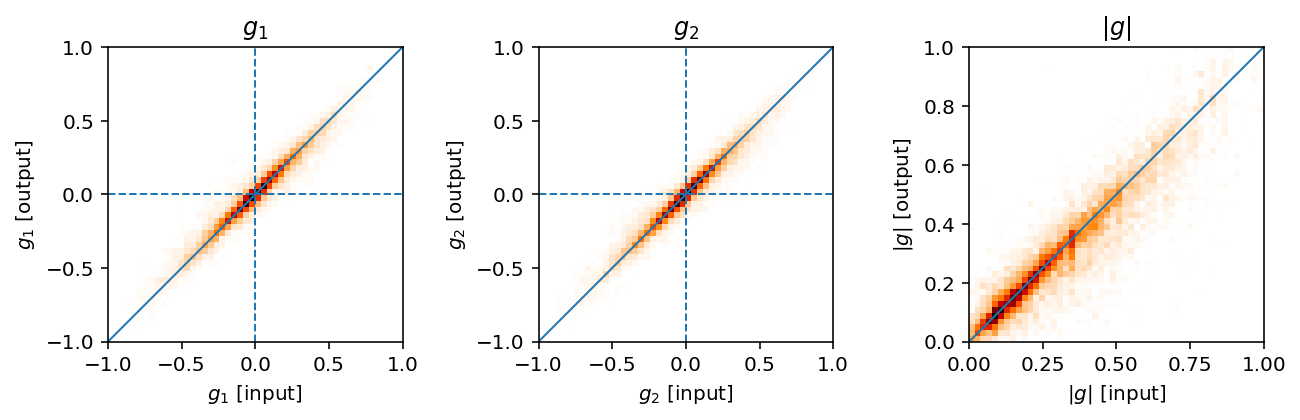

In [17]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_01['e1_in'], df_lsst_01['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_01['e2_in'], df_lsst_01['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_01['e_in'], df_lsst_01['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

plt.tight_layout()

# LSST decentered peak

In [18]:
df_lsst_peak = results_processing.processing(deblender_lsst_peak,
                                              data_dir_peak,
                                              root_peak,
                                              test_sample_peak[0],
                                              bands_lsst,
                                              2,
                                              stamp_size,
                                              batch_size,
                                              psf,
                                              pix_scale_lsst,
                                              n_years)

error for galaxy 2016

(10000, 2, 2)


In [19]:
df_lsst_peak.to_csv('data_v2/df_deblender_lsst_decenter_peak_27.5_v2.csv')

In [8]:
df_lsst_peak = pd.read_csv('data_v2/df_deblender_lsst_decenter_peak_27.5_v2.csv', encoding = 'utf-8')

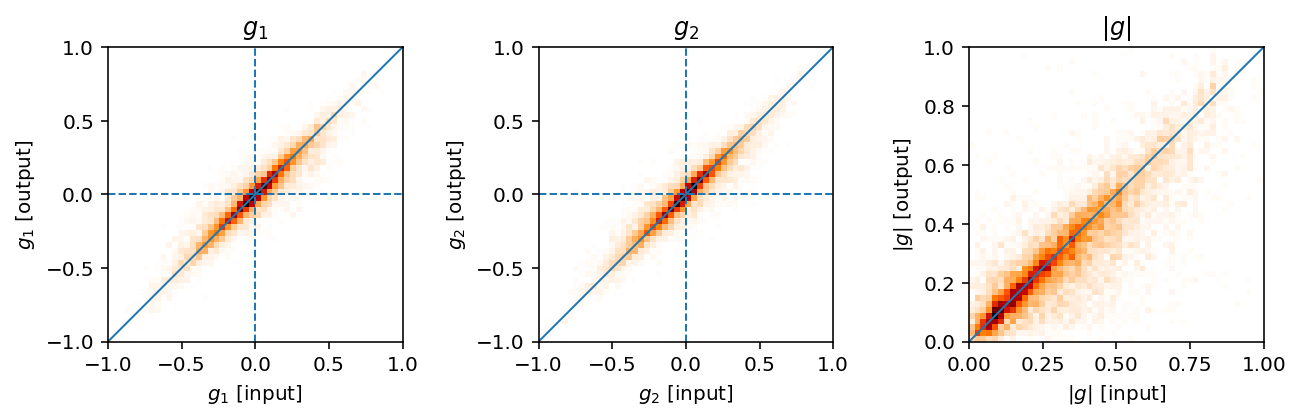

In [20]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e1_in'], df_lsst_peak['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e2_in'], df_lsst_peak['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e_in'], df_lsst_peak['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')


plt.tight_layout()

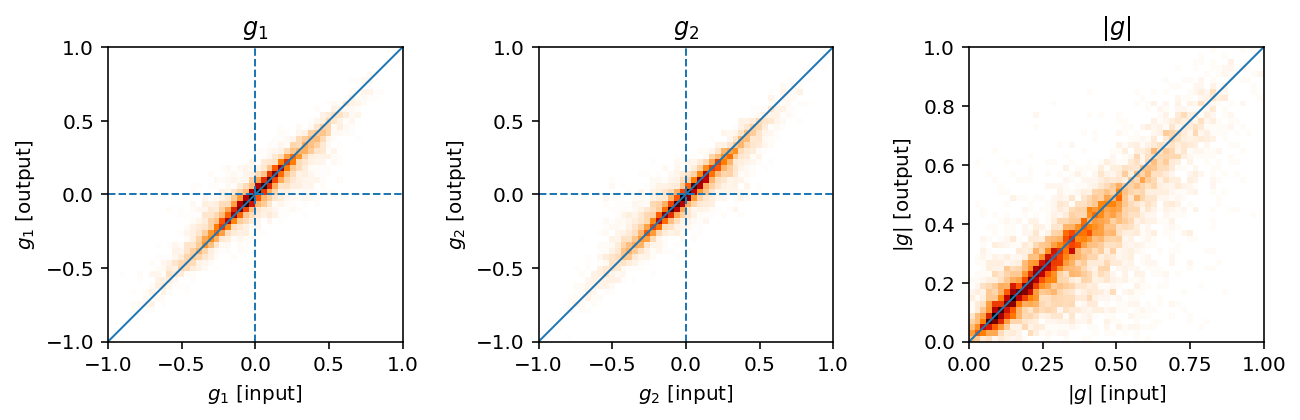

In [14]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e1_in'], df_lsst_peak['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e2_in'], df_lsst_peak['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_peak['e_in'], df_lsst_peak['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')


plt.tight_layout()

# Delta WL parameters

## As function of SNR

In [11]:
df_plot = pd.concat([df_lsst_centered, df_lsst_01, df_lsst_peak], ignore_index=True)
df_plot['exp'] = [1]*10000 + [2]*10000 + [3]*10000

In [12]:
df_plot

,Unnamed: 0,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,...,e_error,e_in_obs,e_out_obs,e_obs_error,flux_in,flux_out,mag_in,mag_out,delta_mag,exp
0,0,2,706.296227,0.596372,0.5391,3.561471,0.205845,0.019063,22.693909,-5.132814,...,-0.001581,0.283781,0.280445,-0.003336,3.546016e+06,3.395121e+06,22.656717,22.703930,0.047213,1
1,1,2,82.488777,0.095915,0.7654,1.969321,-0.259243,0.224808,25.928131,-3.013789,...,0.000321,0.207422,0.216278,0.008856,1.819440e+05,1.853048e+05,25.881224,25.861351,-0.019873,1
2,2,3,22.480838,0.025421,0.2428,2.007041,0.195549,-0.277853,27.055186,-0.506541,...,0.087928,0.195520,0.272885,0.077365,6.129881e+04,4.813780e+04,27.062438,27.324852,0.262414,1
3,3,1,21.911913,0.023381,0.8948,2.058000,-0.551184,-0.356955,27.445184,-0.485815,...,-0.070922,0.421068,0.388224,-0.032844,4.501299e+04,4.675437e+04,27.397724,27.356510,-0.041214,1
4,4,2,892.381174,1.294469,0.3437,2.092752,0.011869,-0.167728,22.640140,-5.151480,...,0.003244,0.111708,0.120523,0.008815,3.508241e+06,3.423215e+06,22.668345,22.694980,0.026636,1
5,5,1,80.901717,0.100924,0.6106,1.769125,-0.112259,0.059851,26.068253,-2.608225,...,-0.049694,0.054905,0.038550,-0.016355,1.598163e+05,1.565563e+05,26.022016,26.044390,0.022374,1
6,6,2,232.256887,0.180059,0.6709,3.081998,0.461416,-0.203852,24.415903,-3.087481,...,-0.011805,0.553823,0.547765,-0.006058,7.329037e+05,6.957530e+05,24.368451,24.424930,0.056479,1
7,7,2,86.638764,0.115129,3.7048,1.602168,-0.292571,-0.044662,26.195682,-1.264591,...,-0.211801,0.076736,0.024371,-0.052364,1.422800e+05,1.417725e+05,26.148208,26.152088,0.003880,1
8,8,1,62.265588,0.079419,0.8739,1.691040,0.378048,-0.254619,26.483742,-2.490330,...,0.013702,0.155864,0.151238,-0.004626,1.091178e+05,1.099544e+05,26.436329,26.428036,-0.008294,1
9,9,4,115.268246,0.112000,0.2035,2.420877,-0.027445,0.621439,25.416379,-1.327997,...,0.081252,0.513998,0.546577,0.032580,2.916434e+05,2.761981e+05,25.368938,25.428015,0.059077,1


In [13]:
df_plot = df_plot.drop('Unnamed: 0', axis = 1)
#df_plot = df_plot.drop('Unnamed: 0.1', axis = 1)

In [14]:
df_plot = df_plot.dropna(axis = 1, how = 'all')

df_plot = df_plot[(df_plot['e1_out']<=1.) & 
                  (df_plot['e2_out']<=1.) &
                  (df_plot['e1_out']>=-1.) & 
                  (df_plot['e2_out']>=-1.) &
                  (df_plot['e_out']>=0.) & 
                  (df_plot['e_out']<=1.) ]

### Error on ellipticity

In [25]:
np.min(df_plot['SNR'])

10.231964715722912

In [33]:
mpl.cm.RdYlBu([0.85, 0.7, 0.6])

array([[0.3609381 , 0.56647443, 0.76163014, 1.        ],
       [0.66635909, 0.84759708, 0.91188005, 1.        ],
       [0.87843137, 0.95294118, 0.97254902, 1.        ]])

In [31]:
sns.color_palette("BrBG", 7)[2]

(0.9434832756632064, 0.8747404844290657, 0.7001153402537484)

In [41]:
reload(boxplot)

<module 'tools_for_VAE.boxplot' from '../../scripts/tools_for_VAE/tools_for_VAE/boxplot.py'>

[1 2 3]
0 1
1 2
2 3


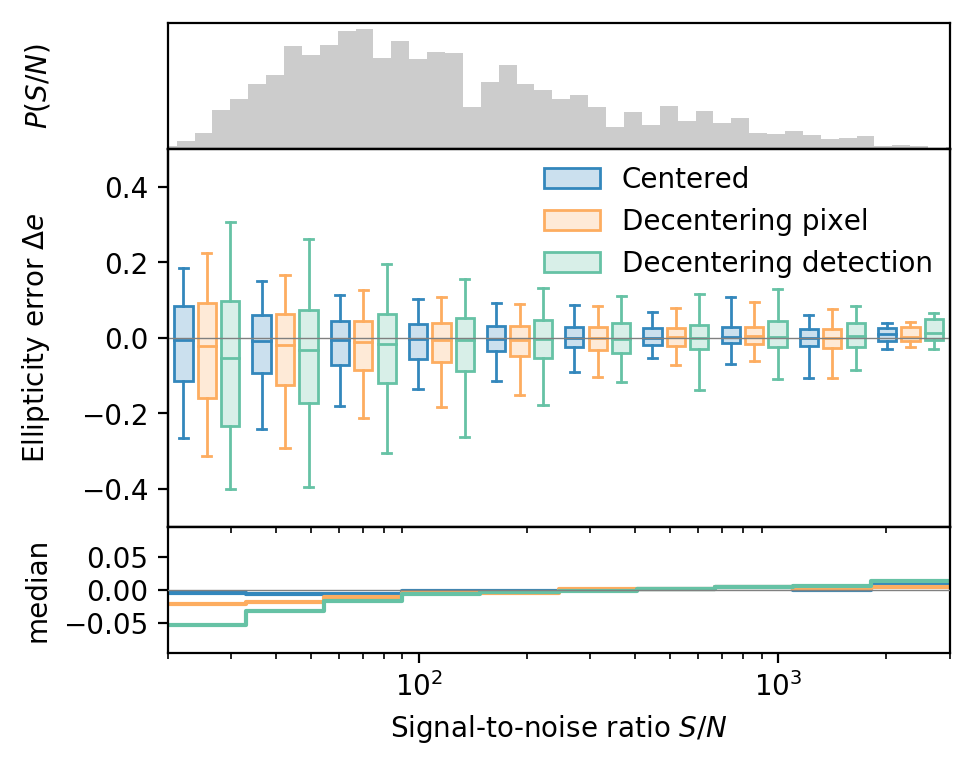

In [85]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (20, 3000),
              ylim = (-0.5, 0.5), 
              ylim2= (-0.095, 0.095),
              x_scale = 'log',
              legend = ['Centered', 'Decentering pixel', 'Decentering detection'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Ellipticity error $\\Delta e$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.Spectral([0.90, 0.30, 0.8]),#sns.color_palette("BrBG", 30),#mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#
              nbins = 10)
fig.savefig('figures_v2/e_snr_c_v4.pdf')

22233
[1 2 3]
0 1
1 2
2 3


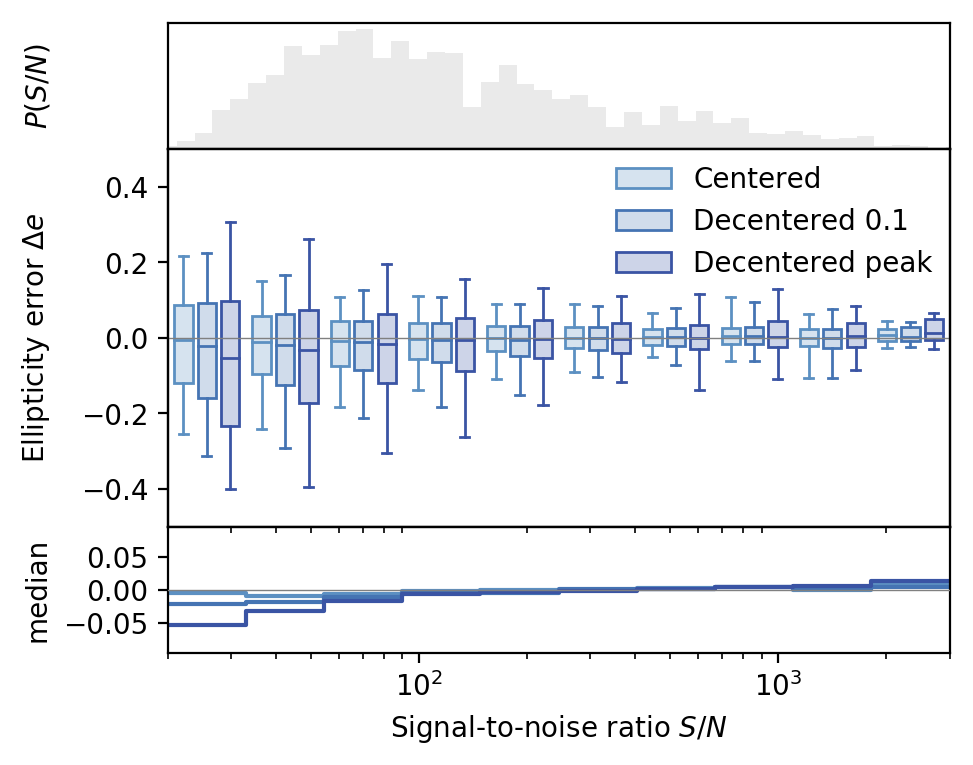

In [12]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (20, 3000),
              ylim = (-0.5, 0.5), 
              ylim2= (-0.095, 0.095),
              x_scale = 'log',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Ellipticity error $\\Delta e$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.85,
              nbins = 10)
#fig.savefig('figures_v2/e_snr_c_v3.pdf')

old

22176
[1 2 3]
0 1
1 2
2 3


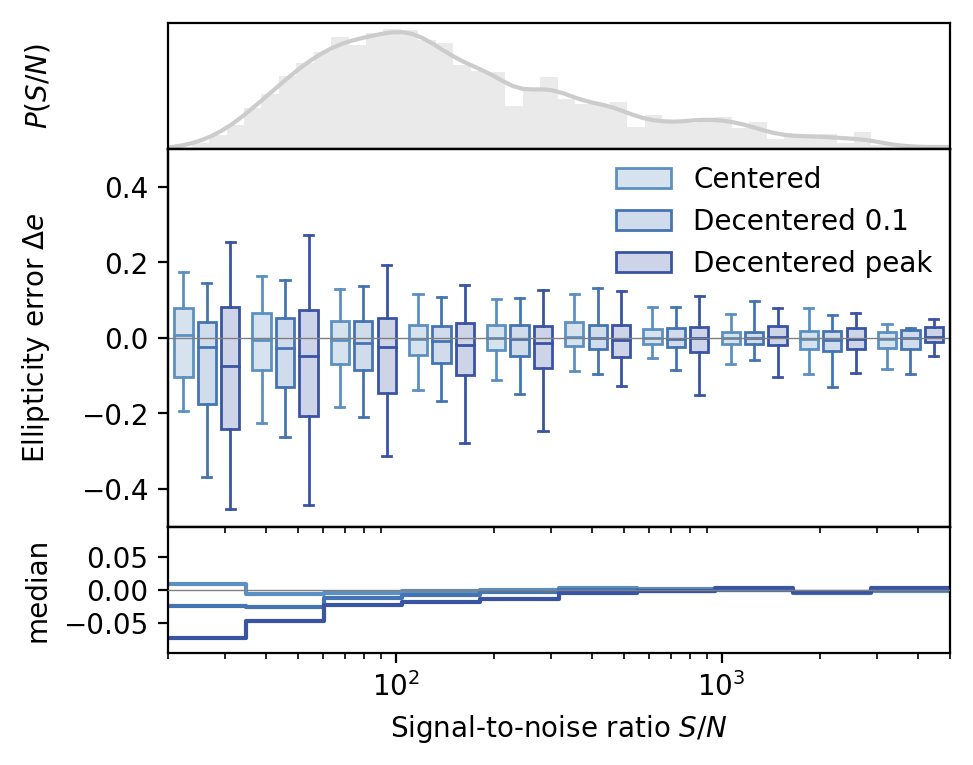

In [15]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (20, 5000),
              ylim = (-0.5, 0.5), 
              ylim2= (-0.095, 0.095),
              x_scale = 'log',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Ellipticity error $\\Delta e$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),#0.85,
              nbins = 10)
#fig.savefig('figures/e_snr_c_v3.pdf')

Magnitude error as function of S/N

[1 2 3]
0 1
1 2
2 3


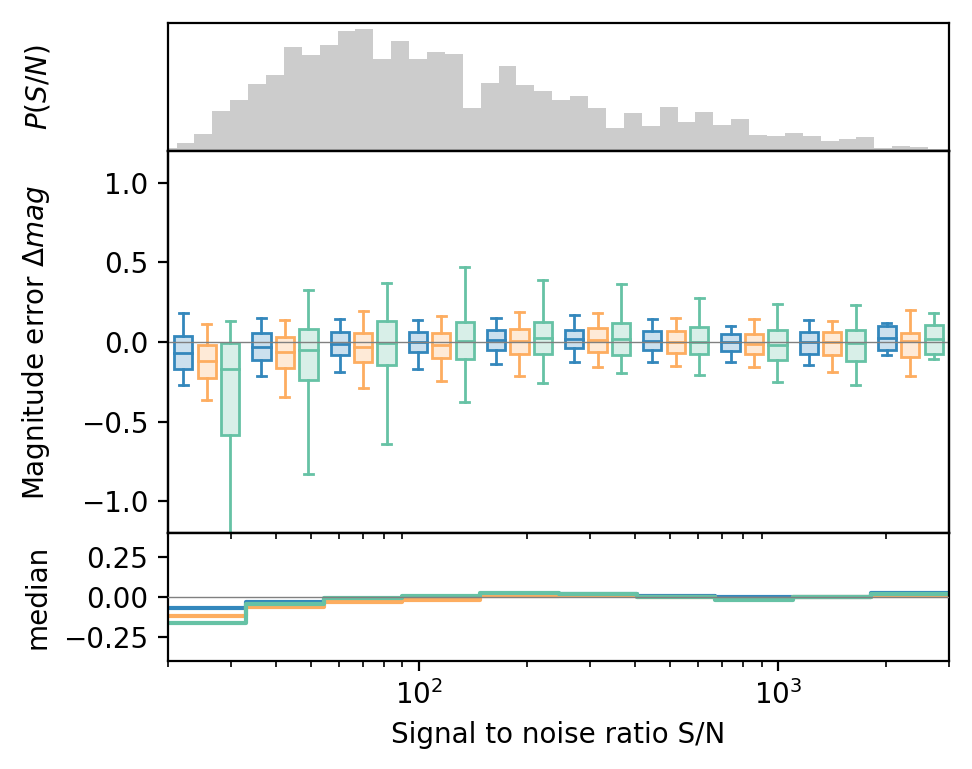

In [93]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot.boxplot_func(df_plot, x = 'SNR', y = 'delta_mag', z = 'exp',
              xlim = (20, 3000),
              ylim = (-1.2,1.2),
              ylim2 = (-0.4,0.4),
              x_scale = 'log',
              legend = ['Centered', 'Decentered pixel', 'Decentered detection'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.Spectral([0.90, 0.30, 0.8]),
              nbins = 10)
fig.savefig('figures_v2/mag_snr_c_v4.pdf')

22233
[1 2 3]
0 1
1 2
2 3


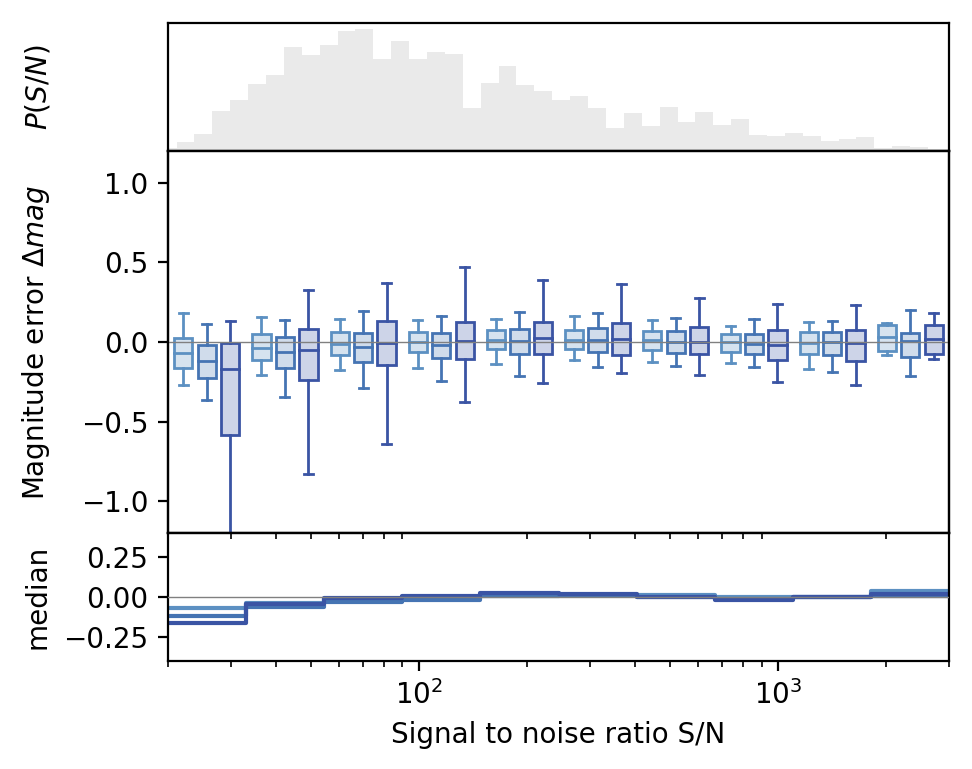

In [16]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'SNR', y = 'delta_mag', z = 'exp',
              xlim = (20, 3000),
              ylim = (-1.2,1.2),
              ylim2 = (-0.4,0.4),
              x_scale = 'log',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures_v2/mag_snr_c_v3.pdf')

old

22176
[1 2 3]
0 1
1 2
2 3


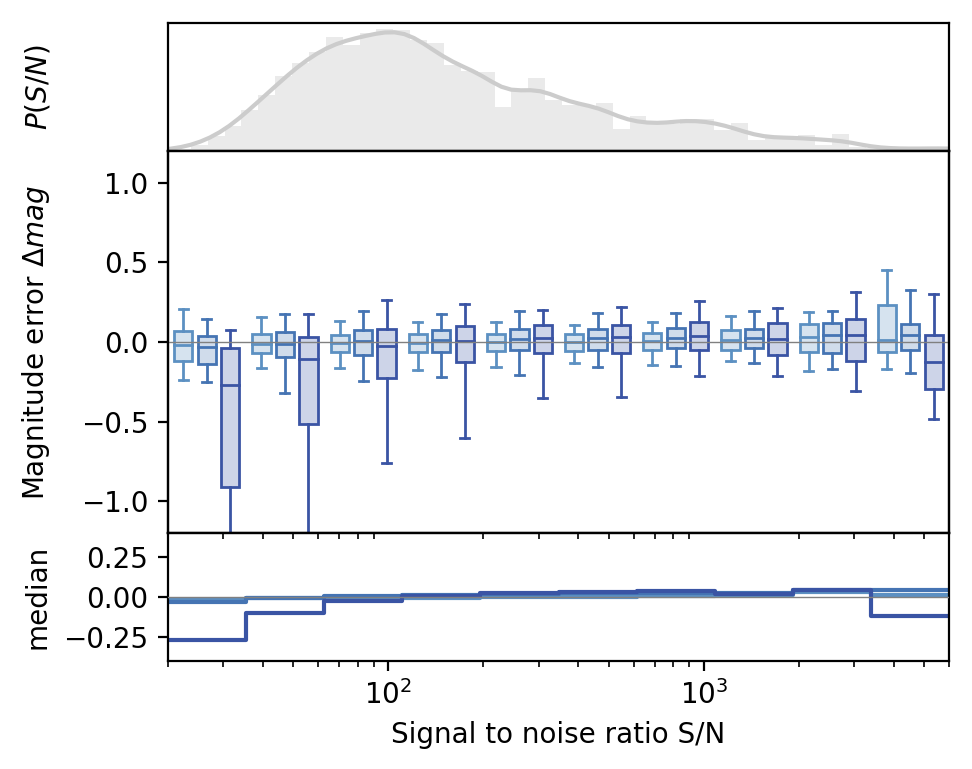

In [12]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'SNR', y = 'delta_mag', z = 'exp',
              xlim = (20, 6000),
              ylim = (-1.2,1.2),
              ylim2 = (-0.4,0.4),
              x_scale = 'log',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/mag_snr_c_v3.pdf')

### Error on flux

In [24]:
np.max(df_plot['mag'])

27.999769667522912

22235
[1 2 3]
0 1
1 2
2 3


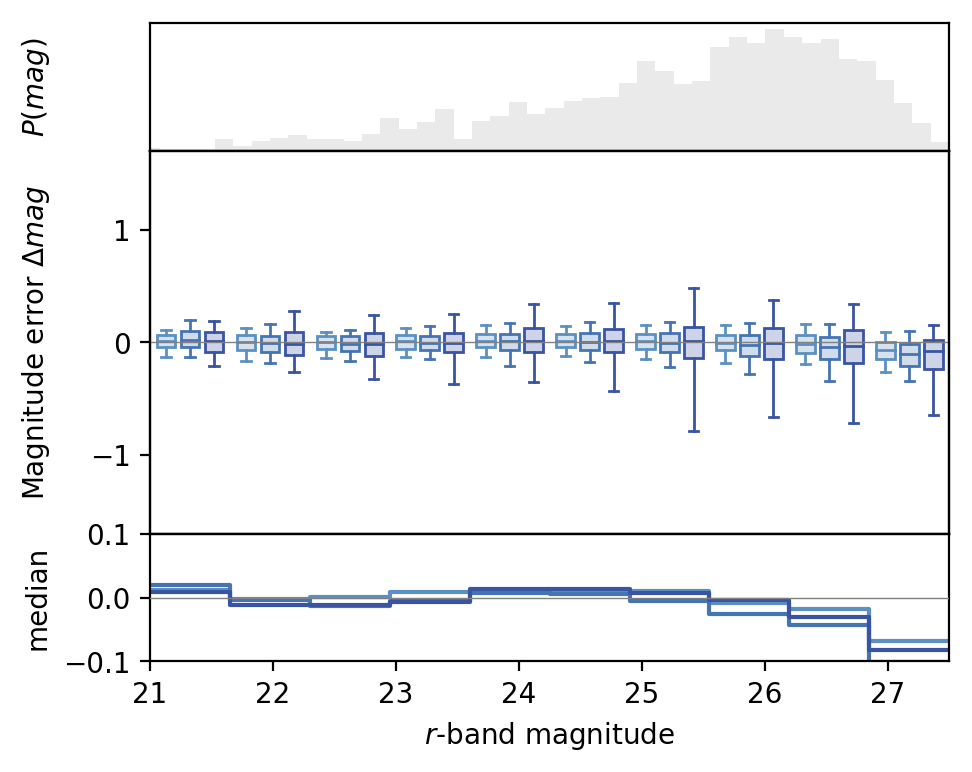

In [223]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'mag', y = 'delta_mag', z = 'exp',
              xlim = (21., 27.5),
              ylim = (-1.7,1.7), 
              ylim2 = (-0.1,0.1), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='$r$-band magnitude', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

old

22176
[1 2 3]
0 1
1 2
2 3


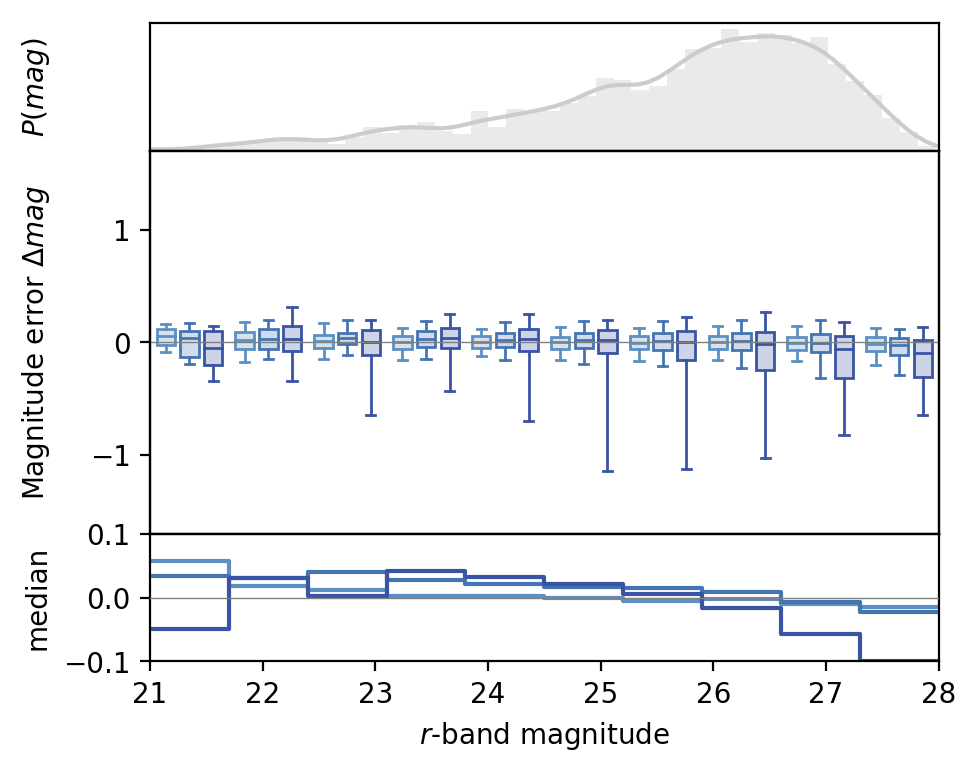

In [11]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'mag', y = 'delta_mag', z = 'exp',
              xlim = (21., 28.),
              ylim = (-1.7,1.7), 
              ylim2 = (-0.1,0.1), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='$r$-band magnitude', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/mag_mag_c_v3.pdf')

In [26]:
len(median_mag), len(median_shear)

(30, 30)

In [17]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = np.abs(median_shear)
df_stat['q1_shear'] = np.abs(q1_shear)
df_stat['q3_shear'] = np.abs(q3_shear)
df_stat['whislo_shear'] = np.abs(whislo_shear)
df_stat['whishi_shear'] = np.abs(whishi_shear)
df_stat['median_mag'] = np.abs(median_mag)
df_stat['q1_mag'] = np.abs(q1_mag)
df_stat['q3_mag'] = np.abs(q3_mag)
df_stat['whislo_mag'] = np.abs(whislo_mag)
df_stat['whishi_mag'] = np.abs(whishi_mag)
df_stat['stats_names'] = ['LSST']*10 + ['LSST Euclid']*10+['r band']*10 

In [18]:
x = 10 # for the first x bins

param = 'median_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.004481480896468497, 0.008833769138027569, 0.01304446164732991]
improvement between each exp: [1.9711718831578124, 2.910748020282587]
mean for each exp: [0.044858237835394256, 0.05424731273761417, 0.07407691569573316]
improvement between each exp: [1.209305477773621, 1.6513558996132622]
mean for each exp: [0.03822698141548353, 0.042894874827865394, 0.05317408942297641]
improvement between each exp: [1.1221099139805784, 1.3910093722817118]
mean for each exp: [0.1256689275274092, 0.13921619187172304, 0.20091106142103027]
improvement between each exp: [1.1078012250988543, 1.5987329992707247]
mean for each exp: [0.10493240576463328, 0.11343068386601338, 0.16359855667327614]
improvement between each exp: [1.0809881183934924, 1.5590851604053841]


In [19]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.01925608581466438, 0.027859996505064277, 0.03090576564988936]
improvement between each exp: [1.4468151405851977, 1.6049869089362503]
mean for each exp: [0.07589897852266023, 0.1080439073469273, 0.16117683447651823]
improvement between each exp: [1.4235225486555125, 2.1235705356482186]
mean for each exp: [0.06401838865968607, 0.05693465712041594, 0.09397074317753591]
improvement between each exp: [0.8893484874021685, 1.467871109300687]
mean for each exp: [0.157936801385965, 0.2327195510803703, 0.43413101499312745]
improvement between each exp: [1.4734979373911192, 2.748764133396628]
mean for each exp: [0.1409502292519246, 0.16090623590264333, 0.29654601794559826]
improvement between each exp: [1.1415819382248096, 2.1039058930196743]


## As a function of blend rate

### As a function of blend rate with closest

#### Error on ellipticity

22233
[1 2 3]
0 1
1 2
2 3


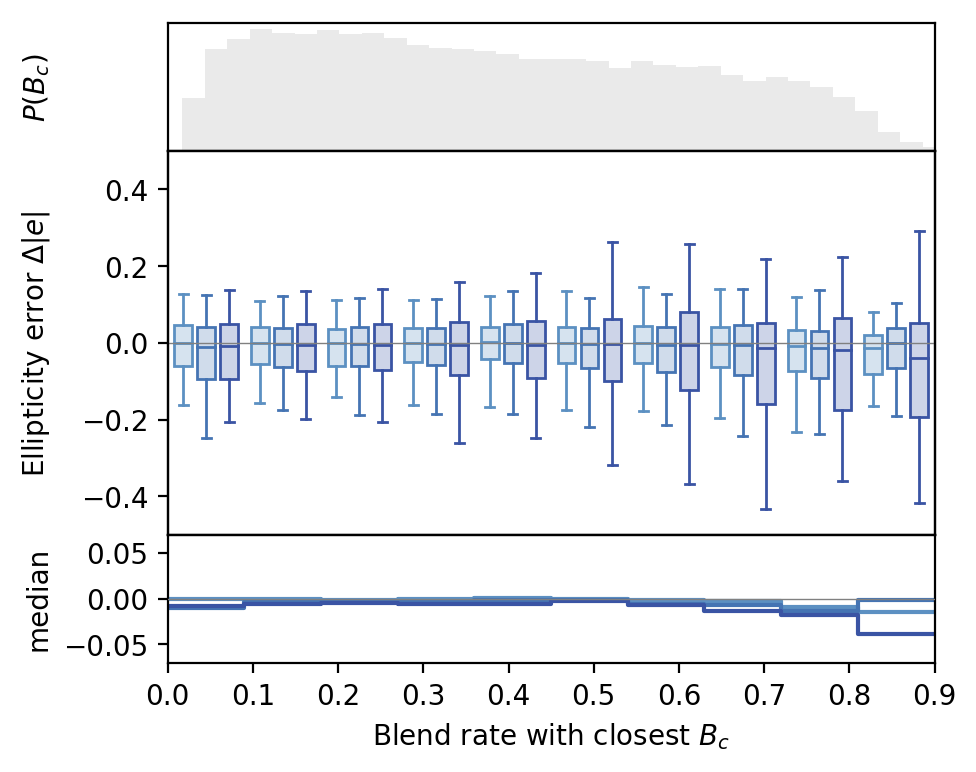

In [49]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, x = 'blendedness_closest_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.9),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Blend rate with closest $B_c$', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

old

22176
[1 2 3]
0 1
1 2
2 3


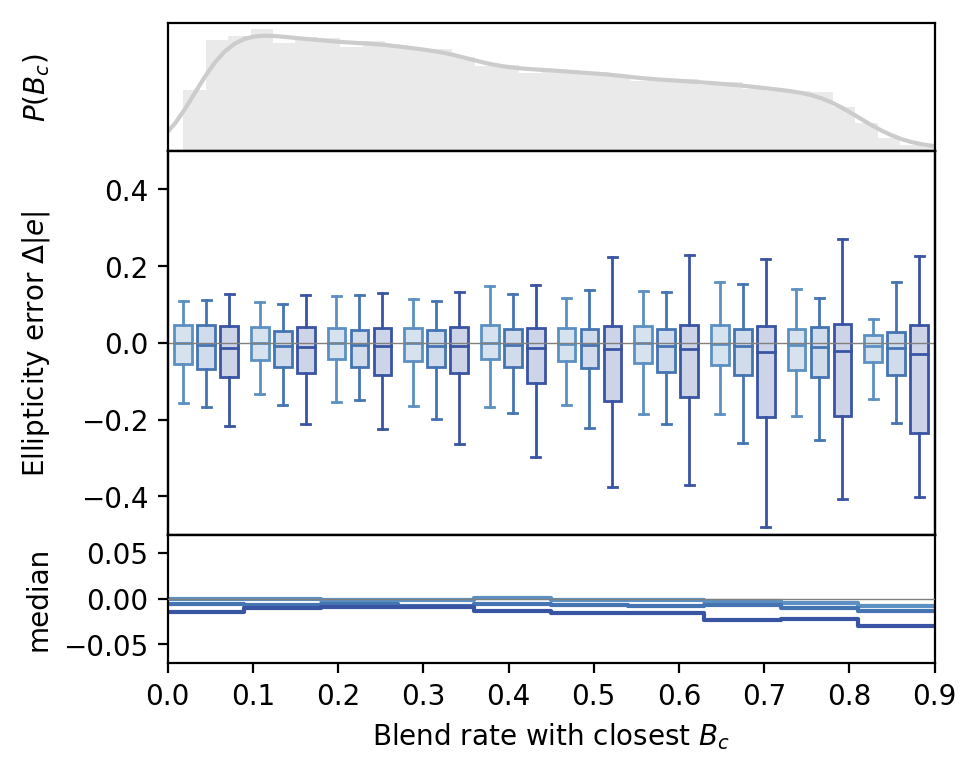

In [15]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, x = 'blendedness_closest_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.9),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Blend rate with closest $B_c$', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/e_b_clos_c_v3.pdf')

#### Error on flux

22233
[1 2 3]
0 1
1 2
2 3


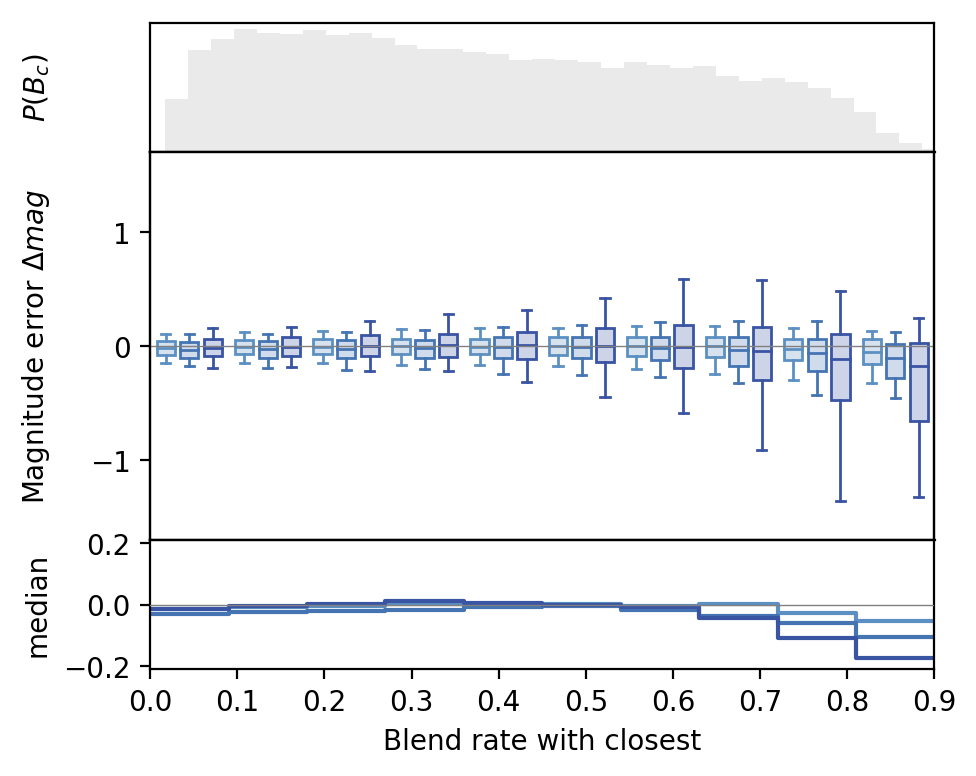

In [50]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'blendedness_closest_lsst', y = 'delta_mag', z = 'exp',
              xlim = (0., 0.9),
              ylim = (-1.7,1.7), 
              ylim2 = (-0.21,0.21),
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Blend rate with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

old

22176
[1 2 3]
0 1
1 2
2 3


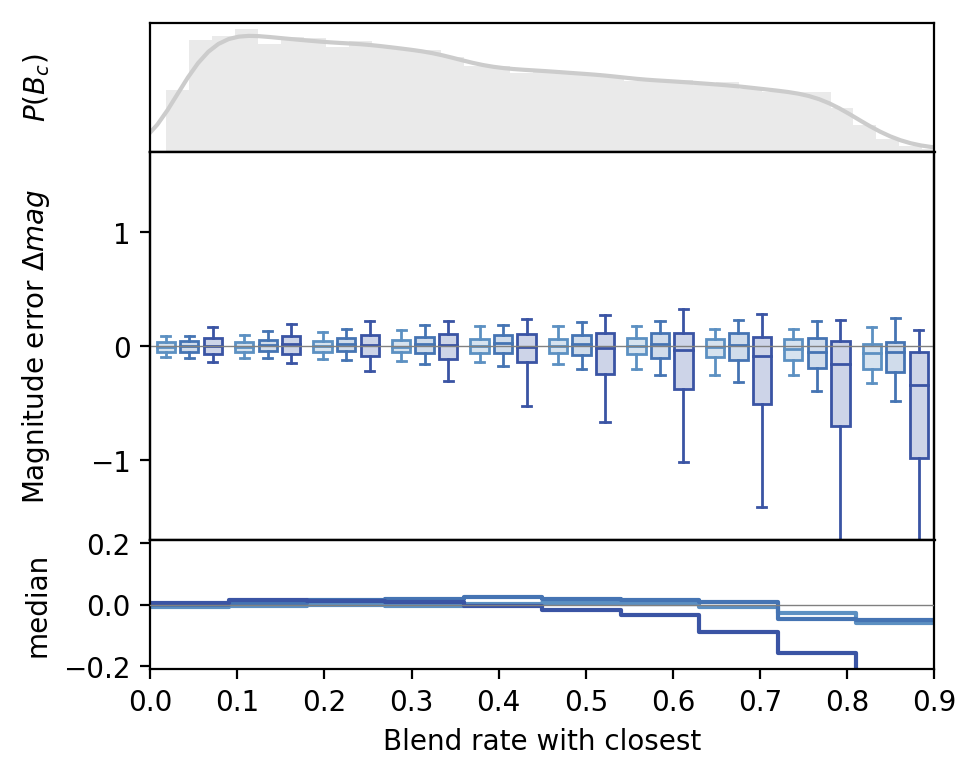

In [33]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'blendedness_closest_lsst', y = 'delta_mag', z = 'exp',
              xlim = (0., 0.9),
              ylim = (-1.7,1.7), 
              ylim2 = (-0.21,0.21),
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Blend rate with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/mag_b_clos_c_v3.pdf')

In [51]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = np.abs(median_shear)
df_stat['q1_shear'] = np.abs(q1_shear)
df_stat['q3_shear'] = np.abs(q3_shear)
df_stat['whislo_shear'] = np.abs(whislo_shear)
df_stat['whishi_shear'] = np.abs(whishi_shear)
df_stat['median_mag'] = np.abs(median_mag)
df_stat['q1_mag'] = np.abs(q1_mag)
df_stat['q3_mag'] = np.abs(q3_mag)
df_stat['whislo_mag'] = np.abs(whislo_mag)
df_stat['whishi_mag'] = np.abs(whishi_mag)
df_stat['stats_names'] = ['LSST']*10 + ['LSST Euclid']*10+['r band']*10 

In [52]:
x = 10 # for the first x bins

param = 'median_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.0031078335071790825, 0.005209170222862909, 0.010854735745736633]
improvement between each exp: [1.6761419847072718, 3.4927018196638393]
mean for each exp: [0.05925153238489933, 0.07096673350054823, 0.11613826984500822]
improvement between each exp: [1.197719799709933, 1.9600888815933286]
mean for each exp: [0.0385890582881558, 0.0403297284332763, 0.05667499488164207]
improvement between each exp: [1.0451078679381707, 1.4686804341902642]
mean for each exp: [0.17331265324875914, 0.20857112623422097, 0.30187611200838765]
improvement between each exp: [1.2034385391057087, 1.7418007649741465]
mean for each exp: [0.12018685517710379, 0.12432784584742729, 0.20109285825386988]
improvement between each exp: [1.0344546054077333, 1.673168483837483]


In [53]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.011541438923502945, 0.03183540863466696, 0.03736383293299008]
improvement between each exp: [2.7583569818003757, 3.2373634847993262]
mean for each exp: [0.08795662796577887, 0.1396993693515353, 0.22008911318332275]
improvement between each exp: [1.5882756374640452, 2.502245916805183]
mean for each exp: [0.0645363015443029, 0.05917325681476919, 0.11290270132955885]
improvement between each exp: [0.9168987902746165, 1.7494448647952558]
mean for each exp: [0.20059137209439867, 0.2761072347249124, 0.5725671529138185]
improvement between each exp: [1.3764661552590398, 2.854395714708843]
mean for each exp: [0.14792635761216957, 0.1617598895845939, 0.3462634619619015]
improvement between each exp: [1.0935163428325112, 2.3407827215601986]


### As a function of total blend rate

#### Error on ellipticity

[1 2 3]
0 1
1 2
2 3


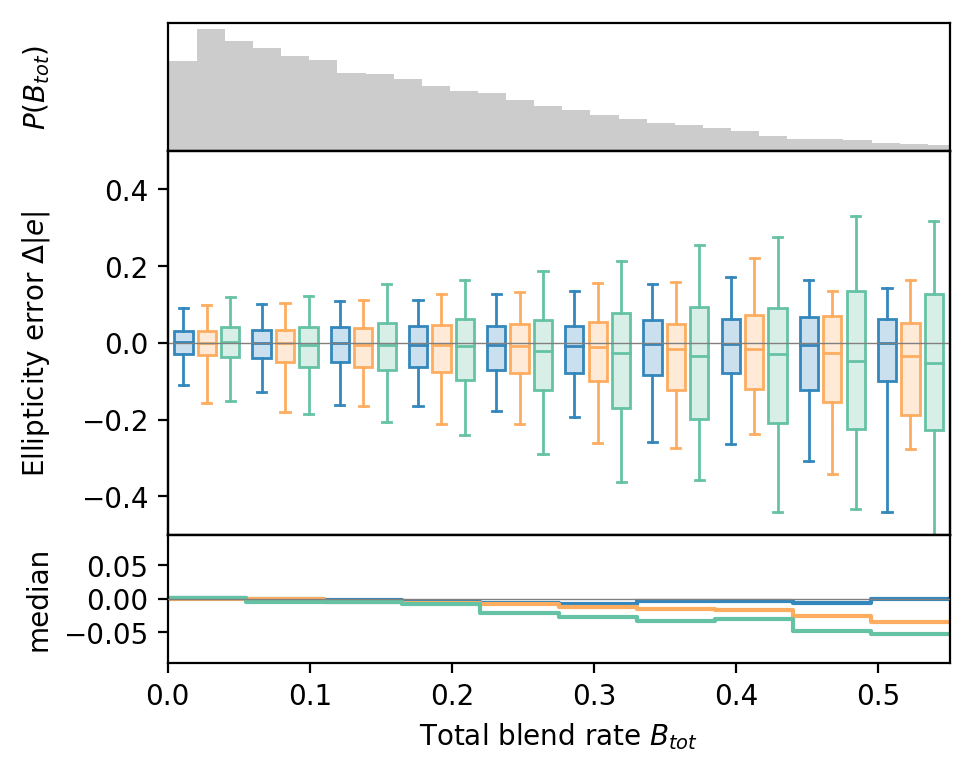

In [92]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, x = 'blendedness_total_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.55),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.095,0.095), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered pixel', 'Decentered detection'],
              x_label='Total blend rate $B_{tot}$', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(B_{tot})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.Spectral([0.90, 0.30, 0.8]),
              nbins = 10)
fig.savefig('figures_v2/e_b_tot_c_v4.pdf')

22233
[1 2 3]
0 1
1 2
2 3


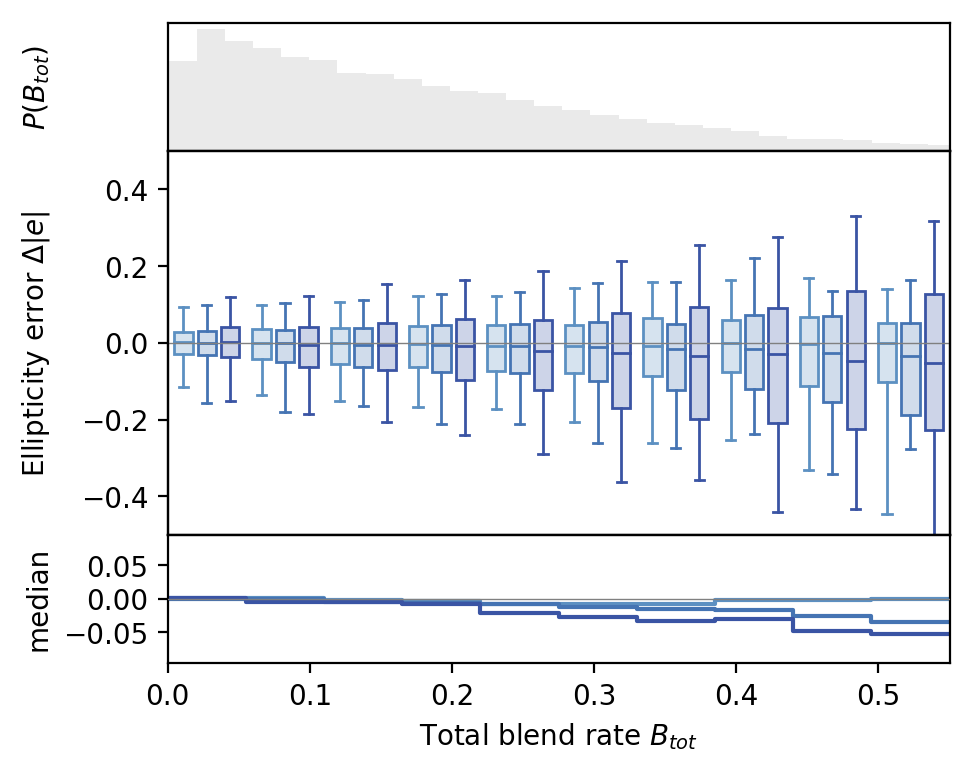

In [37]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, x = 'blendedness_total_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.55),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.095,0.095), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Total blend rate $B_{tot}$', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(B_{tot})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)
#fig.savefig('figures_v2/e_b_tot_c_v3.pdf')

old

22176
[1 2 3]
0 1
1 2
2 3


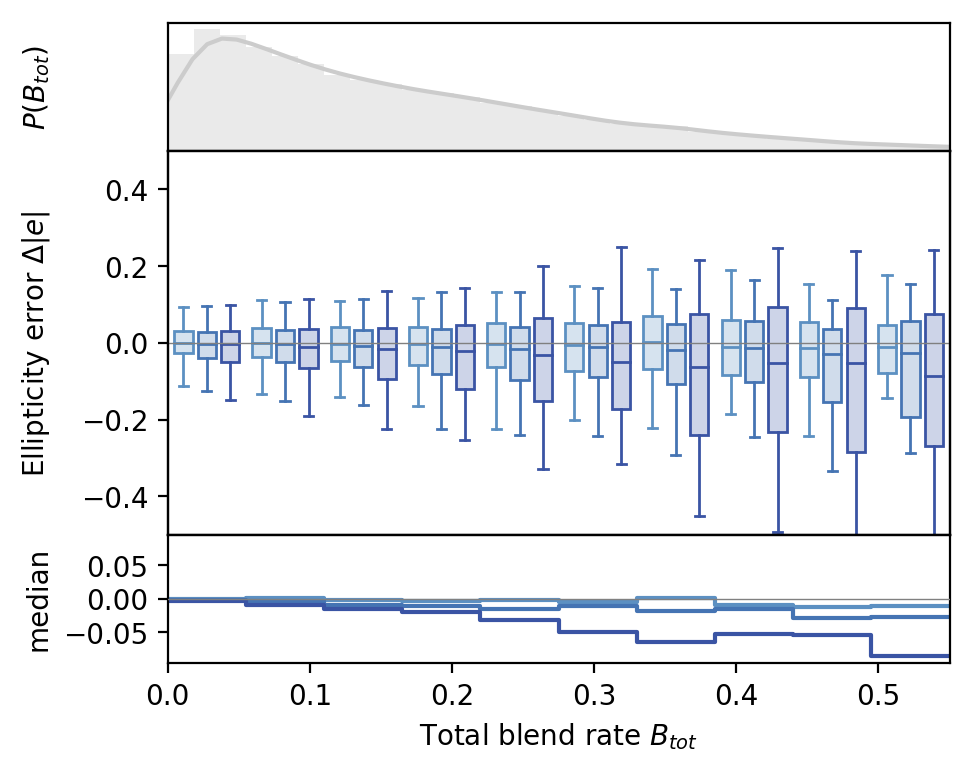

In [16]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, x = 'blendedness_total_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.55),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.095,0.095), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Total blend rate $B_{tot}$', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(B_{tot})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/e_b_tot_c_v3.pdf')

#### Error on flux

[1 2 3]
0 1
1 2
2 3


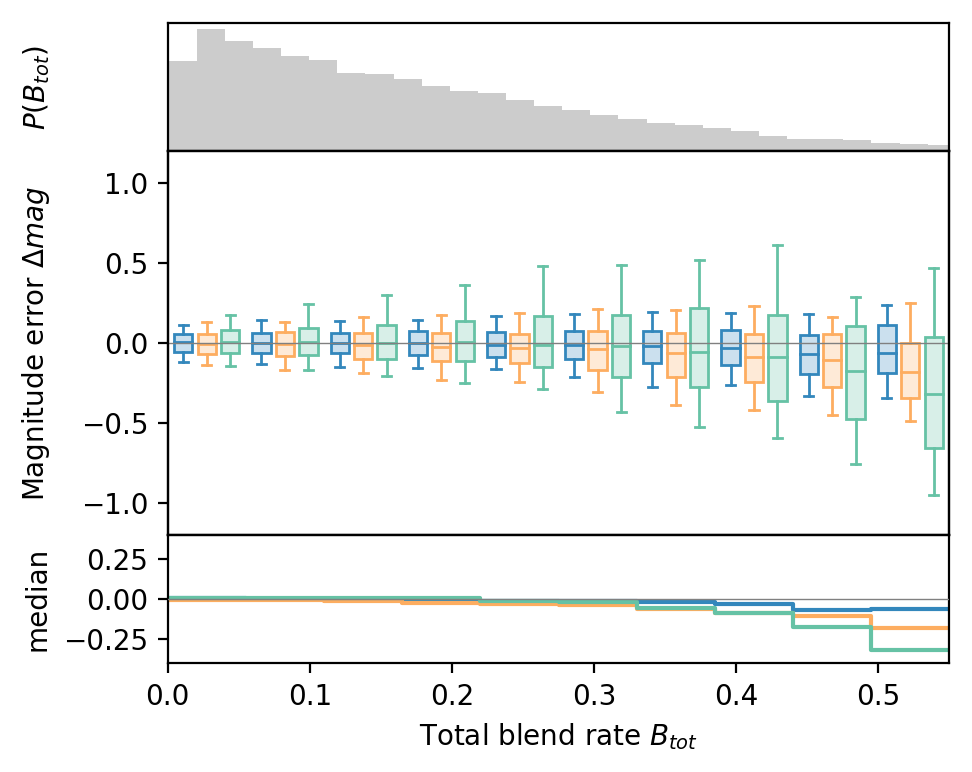

In [91]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot.boxplot_func(df_plot, x = 'blendedness_total_lsst', y = 'delta_mag', z = 'exp',
              xlim = (0., .55),
              ylim = (-1.2,1.2), 
              ylim2 = (-0.4,0.4),
              x_scale = 'linear',
              legend = ['Centered', 'Decentered pixel', 'Decentered detection'],
              x_label='Total blend rate $B_{tot}$', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{tot})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.Spectral([0.90, 0.30, 0.8]),
              nbins = 10)

fig.savefig('figures_v2/mag_b_tot_c_v4.pdf')

22233
[1 2 3]
0 1
1 2
2 3


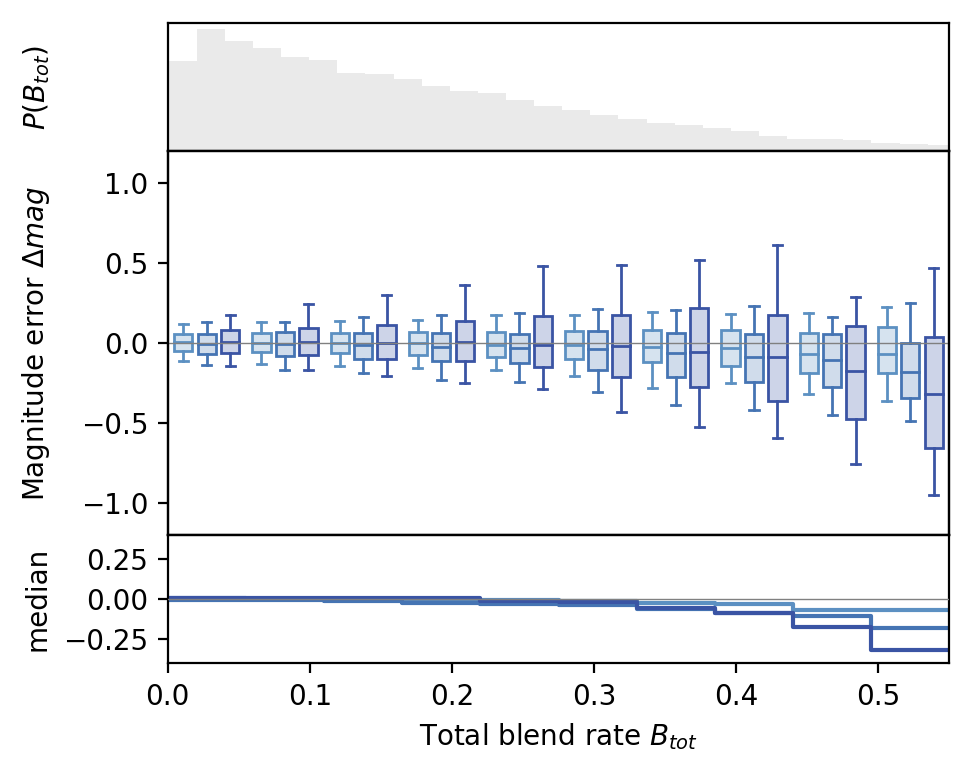

In [38]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'blendedness_total_lsst', y = 'delta_mag', z = 'exp',
              xlim = (0., .55),
              ylim = (-1.2,1.2), 
              ylim2 = (-0.4,0.4),
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Total blend rate $B_{tot}$', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{tot})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures_v2/mag_b_tot_c_v3.pdf')

old

In [ ]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'blendedness_total_lsst', y = 'delta_mag', z = 'exp',
              xlim = (0., .55),
              ylim = (-1.2,1.2), 
              ylim2 = (-0.4,0.4),
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='Total blend rate $B_{tot}$', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{tot})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/mag_b_tot_c_v3.pdf')

22176
[1 2 3]
0 1


In [39]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = np.abs(median_shear)
df_stat['q1_shear'] = np.abs(q1_shear)
df_stat['q3_shear'] = np.abs(q3_shear)
df_stat['whislo_shear'] = np.abs(whislo_shear)
df_stat['whishi_shear'] = np.abs(whishi_shear)
df_stat['median_mag'] = np.abs(median_mag)
df_stat['q1_mag'] = np.abs(q1_mag)
df_stat['q3_mag'] = np.abs(q3_mag)
df_stat['whislo_mag'] = np.abs(whislo_mag)
df_stat['whishi_mag'] = np.abs(whishi_mag)
df_stat['stats_names'] = ['LSST']*10 + ['LSST Euclid']*10+['r band']*10 


In [40]:
x = 10 # for the first x bins

param = 'median_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.0035378552703612385, 0.012539042685726389, 0.02306561608554168]
improvement between each exp: [3.5442497579744323, 6.519660733093394]
mean for each exp: [0.07187767403455816, 0.09848144634656983, 0.1416105200298569]
improvement between each exp: [1.3701256707224667, 1.9701600244016215]
mean for each exp: [0.048224991100911316, 0.04980979732219336, 0.07819372903343777]
improvement between each exp: [1.032862758190371, 1.6214358416327448]
mean for each exp: [0.22391900041117396, 0.23135777509351346, 0.318660648148781]
improvement between each exp: [1.03322082837401, 1.4231067822008696]
mean for each exp: [0.13184780706106777, 0.14122118152634255, 0.21388792315874428]
improvement between each exp: [1.0710923804817878, 1.6222334517833739]


In [41]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.023649337746335597, 0.05703495173320201, 0.06898577111074884]
improvement between each exp: [2.4116933989849008, 2.9170276077366273]
mean for each exp: [0.10945906334961655, 0.17443215214226965, 0.25006171476589933]
improvement between each exp: [1.5935834530679884, 2.2845226983826126]
mean for each exp: [0.07080051528104966, 0.05528915601362135, 0.13041892419294637]
improvement between each exp: [0.7809145991967088, 1.8420617939747406]
mean for each exp: [0.21530978224271174, 0.30438315188564447, 0.4325470860142543]
improvement between each exp: [1.4136986657787949, 2.0089523174876374]
mean for each exp: [0.1672686561486973, 0.18402467790641666, 0.39224492927944626]
improvement between each exp: [1.100174307270238, 2.344999585162872]


## As a function of delta magnitude

### Error on ellipticity

In [42]:
df_plot['delta_mag_closest'] = df_plot['closest_mag'] - df_plot['mag']

22233
[1 2 3]
0 1
1 2
2 3


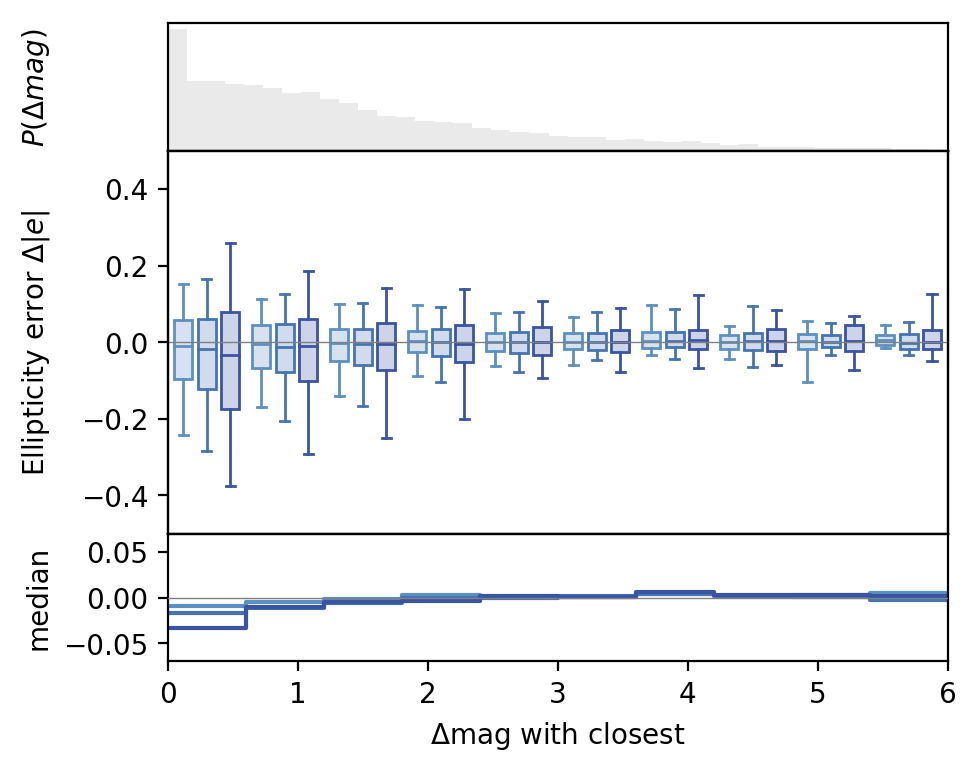

In [43]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, x = 'delta_mag_closest', y = 'e_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

old

22176
[1 2 3]
0 1
1 2
2 3


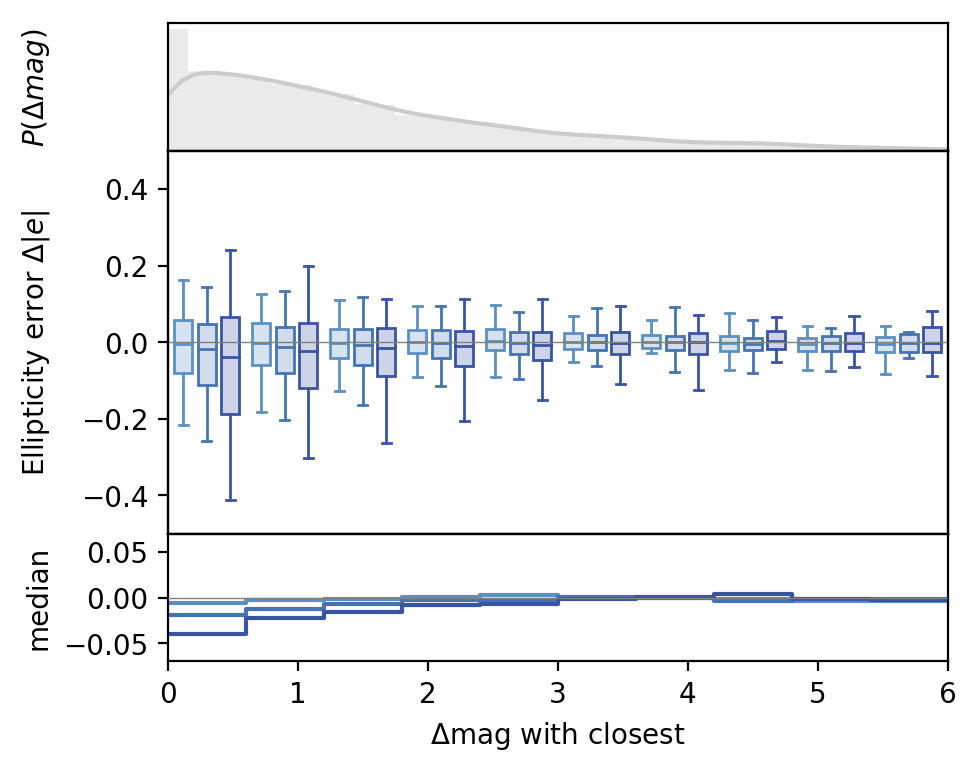

In [19]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, x = 'delta_mag_closest', y = 'e_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/e_mag_clos_c_v3.pdf')

### Error on flux

22233
[1 2 3]
0 1
1 2
2 3


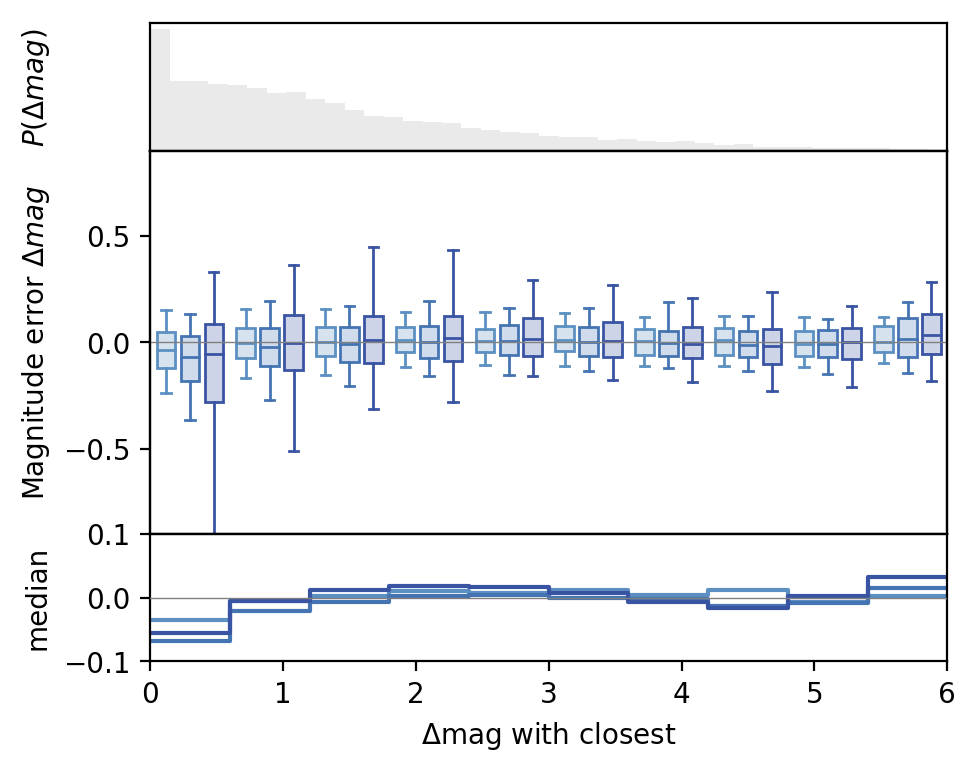

In [44]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'delta_mag_closest', y = 'delta_mag', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

old

22176
[1 2 3]
0 1
1 2
2 3


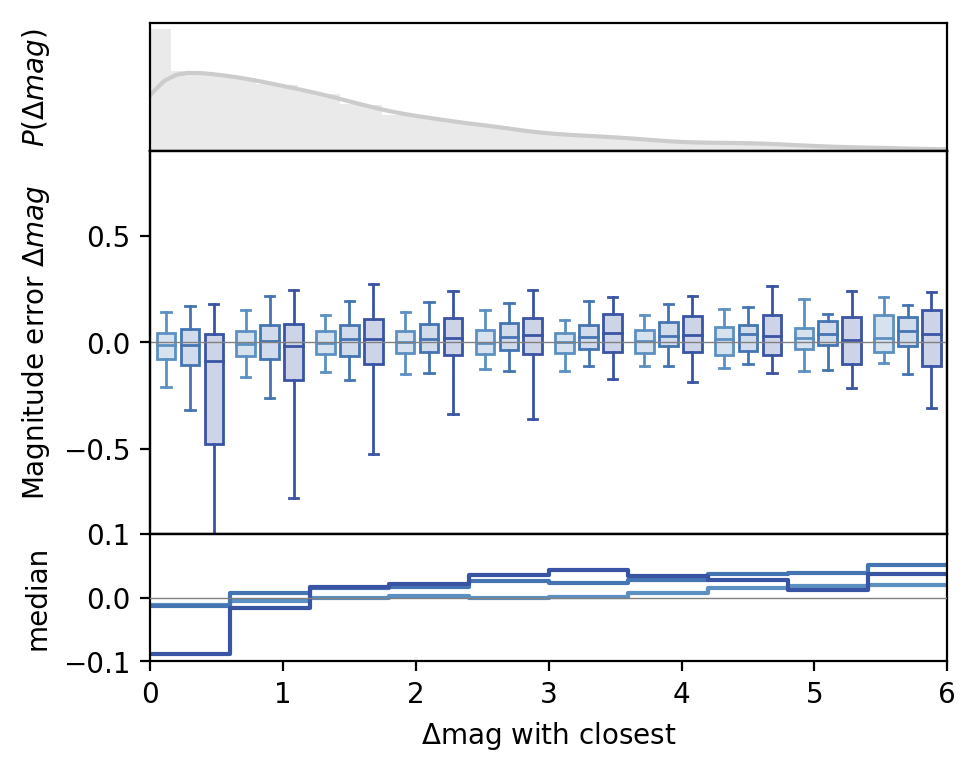

In [44]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, x = 'delta_mag_closest', y = 'delta_mag', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['Centered', 'Decentered 0.1', 'Decentered peak'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85, 0.90, 0.95]),
              nbins = 10)

#fig.savefig('figures/mag_mag_clos_c_v3.pdf')

In [45]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = np.abs(median_shear)
df_stat['q1_shear'] = np.abs(q1_shear)
df_stat['q3_shear'] = np.abs(q3_shear)
df_stat['whislo_shear'] = np.abs(whislo_shear)
df_stat['whishi_shear'] = np.abs(whishi_shear)
df_stat['median_mag'] = np.abs(median_mag)
df_stat['q1_mag'] = np.abs(q1_mag)
df_stat['q3_mag'] = np.abs(q3_mag)
df_stat['whislo_mag'] = np.abs(whislo_mag)
df_stat['whishi_mag'] = np.abs(whishi_mag)
df_stat['stats_names'] = ['LSST']*10 + ['LSST Euclid']*10+['r band']*10 

In [47]:
x = 10 # for the first x bins

param = 'median_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.003354974582581991, 0.004780065256319555, 0.006719748731900242]
improvement between each exp: [1.4247694397257737, 2.002920906401836]
mean for each exp: [0.03376973878030114, 0.04052928655351292, 0.05418453565476378]
improvement between each exp: [1.2001658294483113, 1.6045293097254036]
mean for each exp: [0.030293233705676804, 0.031797658129089516, 0.04513693080411058]
improvement between each exp: [1.0496620611067609, 1.490000415361802]
mean for each exp: [0.09587424895246469, 0.10602244551087722, 0.15373033574209466]
improvement between each exp: [1.1058490331793274, 1.603458044488208]
mean for each exp: [0.08425356882120674, 0.09235353627822453, 0.1326214693906373]
improvement between each exp: [1.0961379745730013, 1.5740753922492157]


In [48]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q1_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'q3_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whislo_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))
param = 'whishi_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][:10]) , np.mean(df_stat[param][20:20+x])/np.mean(df_stat[param][:10])]))

mean for each exp: [0.009578123042764198, 0.014189564163142609, 0.017108227867931092]
improvement between each exp: [1.4814556150290978, 1.7861774996569415]
mean for each exp: [0.062158147213830305, 0.08581342930088828, 0.10421440231760806]
improvement between each exp: [1.3805660745594848, 1.676600847819675]
mean for each exp: [0.06541582906491719, 0.06725498251236572, 0.10018960066362478]
improvement between each exp: [1.028114807589206, 1.5315803849890657]
mean for each exp: [0.13366278619802507, 0.18459290674446382, 0.32320367459418264]
improvement between each exp: [1.3810344075200136, 2.4180528012886664]
mean for each exp: [0.1363668872274147, 0.1619017601125991, 0.3029923595534381]
improvement between each exp: [1.1872512704832863, 2.2218910009154014]


# Bias

In [95]:
df_lsst_euclid = pd.read_csv('data_v2/df_deb_centered_lsst_euclid__27.5_v2.csv', encoding = 'utf-8')

In [96]:
df_bias = pd.DataFrame()
param = 'SNR'
#df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & (df_lsst_euclid['e2_out']<=1.)]

bins = np.geomspace(20, 5000, 10)
#bins = np.linspace(0.1, 1, 10)

for k in range (2):
    slope = []
    intercept = []
    std_err = []
    bins_list = []

    bining_temp = 10
    mask = ~np.isnan(df_lsst_centered['e_in']) & ~np.isnan(df_lsst_centered['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_centered[(df_lsst_centered['e1_out']<=1.) & 
                          (df_lsst_centered['e2_out']<=1.) &
                          (df_lsst_centered['e_out']>=0.) & 
                          (df_lsst_centered['e_out']<=1.) &
                          (bining_temp <= df_lsst_centered[param]) &
                          (df_lsst_centered[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & 
                                 (df_lsst_euclid['e2_out']<=1.) &
                                 (df_lsst_euclid['e_out']>=0.) & 
                                 (df_lsst_euclid['e_out']<=1.) &
                                 (bining_temp <= df_lsst_euclid[param]) &
                                 (df_lsst_euclid[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_01['e_in']) & ~np.isnan(df_lsst_01['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_01[(df_lsst_01['e1_out']<=1.) & 
                                 (df_lsst_01['e2_out']<=1.) &
                                 (df_lsst_01['e_out']>=0.) & 
                                 (df_lsst_01['e_out']<=1.) &
                                 (bining_temp <= df_lsst_01[param]) &
                                 (df_lsst_01[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_peak['e_in']) & ~np.isnan(df_lsst_peak['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_peak[(df_lsst_peak['e1_out']<=1.) & 
                                 (df_lsst_peak['e2_out']<=1.) &
                                 (df_lsst_peak['e_out']>=0.) & 
                                 (df_lsst_peak['e_out']<=1.) &
                                 (bining_temp <= df_lsst_peak[param]) &
                                 (df_lsst_peak[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining
              
    df_bias['slope_e'+str(k+1)] = np.array(slope)
    df_bias['intercept_e'+str(k+1)] = np.array(intercept)
    df_bias['std_err_e'+str(k+1)] = np.array(std_err)

In [97]:
list_mid_bins = []
idx_temp = 10
for i, idx in enumerate (bins_list):
    if i == 10:
        idx_temp = 10
    if i == 20:
        idx_temp = 10
    if i == 30:
        idx_temp = 10

    list_mid_bins.append(idx - (idx - idx_temp)/2)
    idx_temp = idx

In [98]:
df_bias['Experience'] = len(bins)*['LSST'] + len(bins)*['LSST+Euclid']+ len(bins)*['LSST 01'] + len(bins)*['LSST peak']
df_bias['bins_list'] = np.array(list_mid_bins)
df_bias['mean_g'] = np.mean([df_bias['slope_e1'],df_bias['slope_e2']], axis = 0)
df_bias['mean_stderr'] = np.mean([df_bias['std_err_e1'],df_bias['std_err_e2']], axis = 0)

In [99]:
df_bias

,slope_e1,intercept_e1,std_err_e1,slope_e2,intercept_e2,std_err_e2,Experience,bins_list,mean_g,mean_stderr
0,-0.211416,0.027266,0.042725,-0.176612,0.016674,0.038736,LSST,15.000000,-0.194014,0.040730
1,-0.129609,0.003262,0.009019,-0.115791,-0.006539,0.009524,LSST,28.468762,-0.122700,0.009271
2,-0.086380,0.001170,0.005244,-0.090567,-0.001865,0.005198,LSST,52.578278,-0.088473,0.005221
3,-0.056493,0.000008,0.004613,-0.059525,-0.001221,0.004330,LSST,97.105569,-0.058009,0.004471
4,-0.015425,0.000357,0.004224,-0.012237,-0.001621,0.004182,LSST,179.341961,-0.013831,0.004203
5,-0.003205,0.000771,0.004154,-0.008367,-0.000873,0.003842,LSST,331.222395,-0.005786,0.003998
6,0.005120,0.003195,0.004382,0.005019,0.000995,0.004416,LSST,611.726749,0.005070,0.004399
7,0.007259,-0.001183,0.007546,0.035715,-0.001938,0.007140,LSST,1129.783559,0.021487,0.007343
8,-0.014307,-0.002802,0.013368,-0.007651,-0.001801,0.012241,LSST,2086.570337,-0.010979,0.012805
9,0.024684,-0.004415,0.009865,0.000992,0.005140,0.010437,LSST,3853.637041,0.012838,0.010151


['Experience', 'LSST', 'LSST+Euclid', 'LSST 01', 'LSST peak']


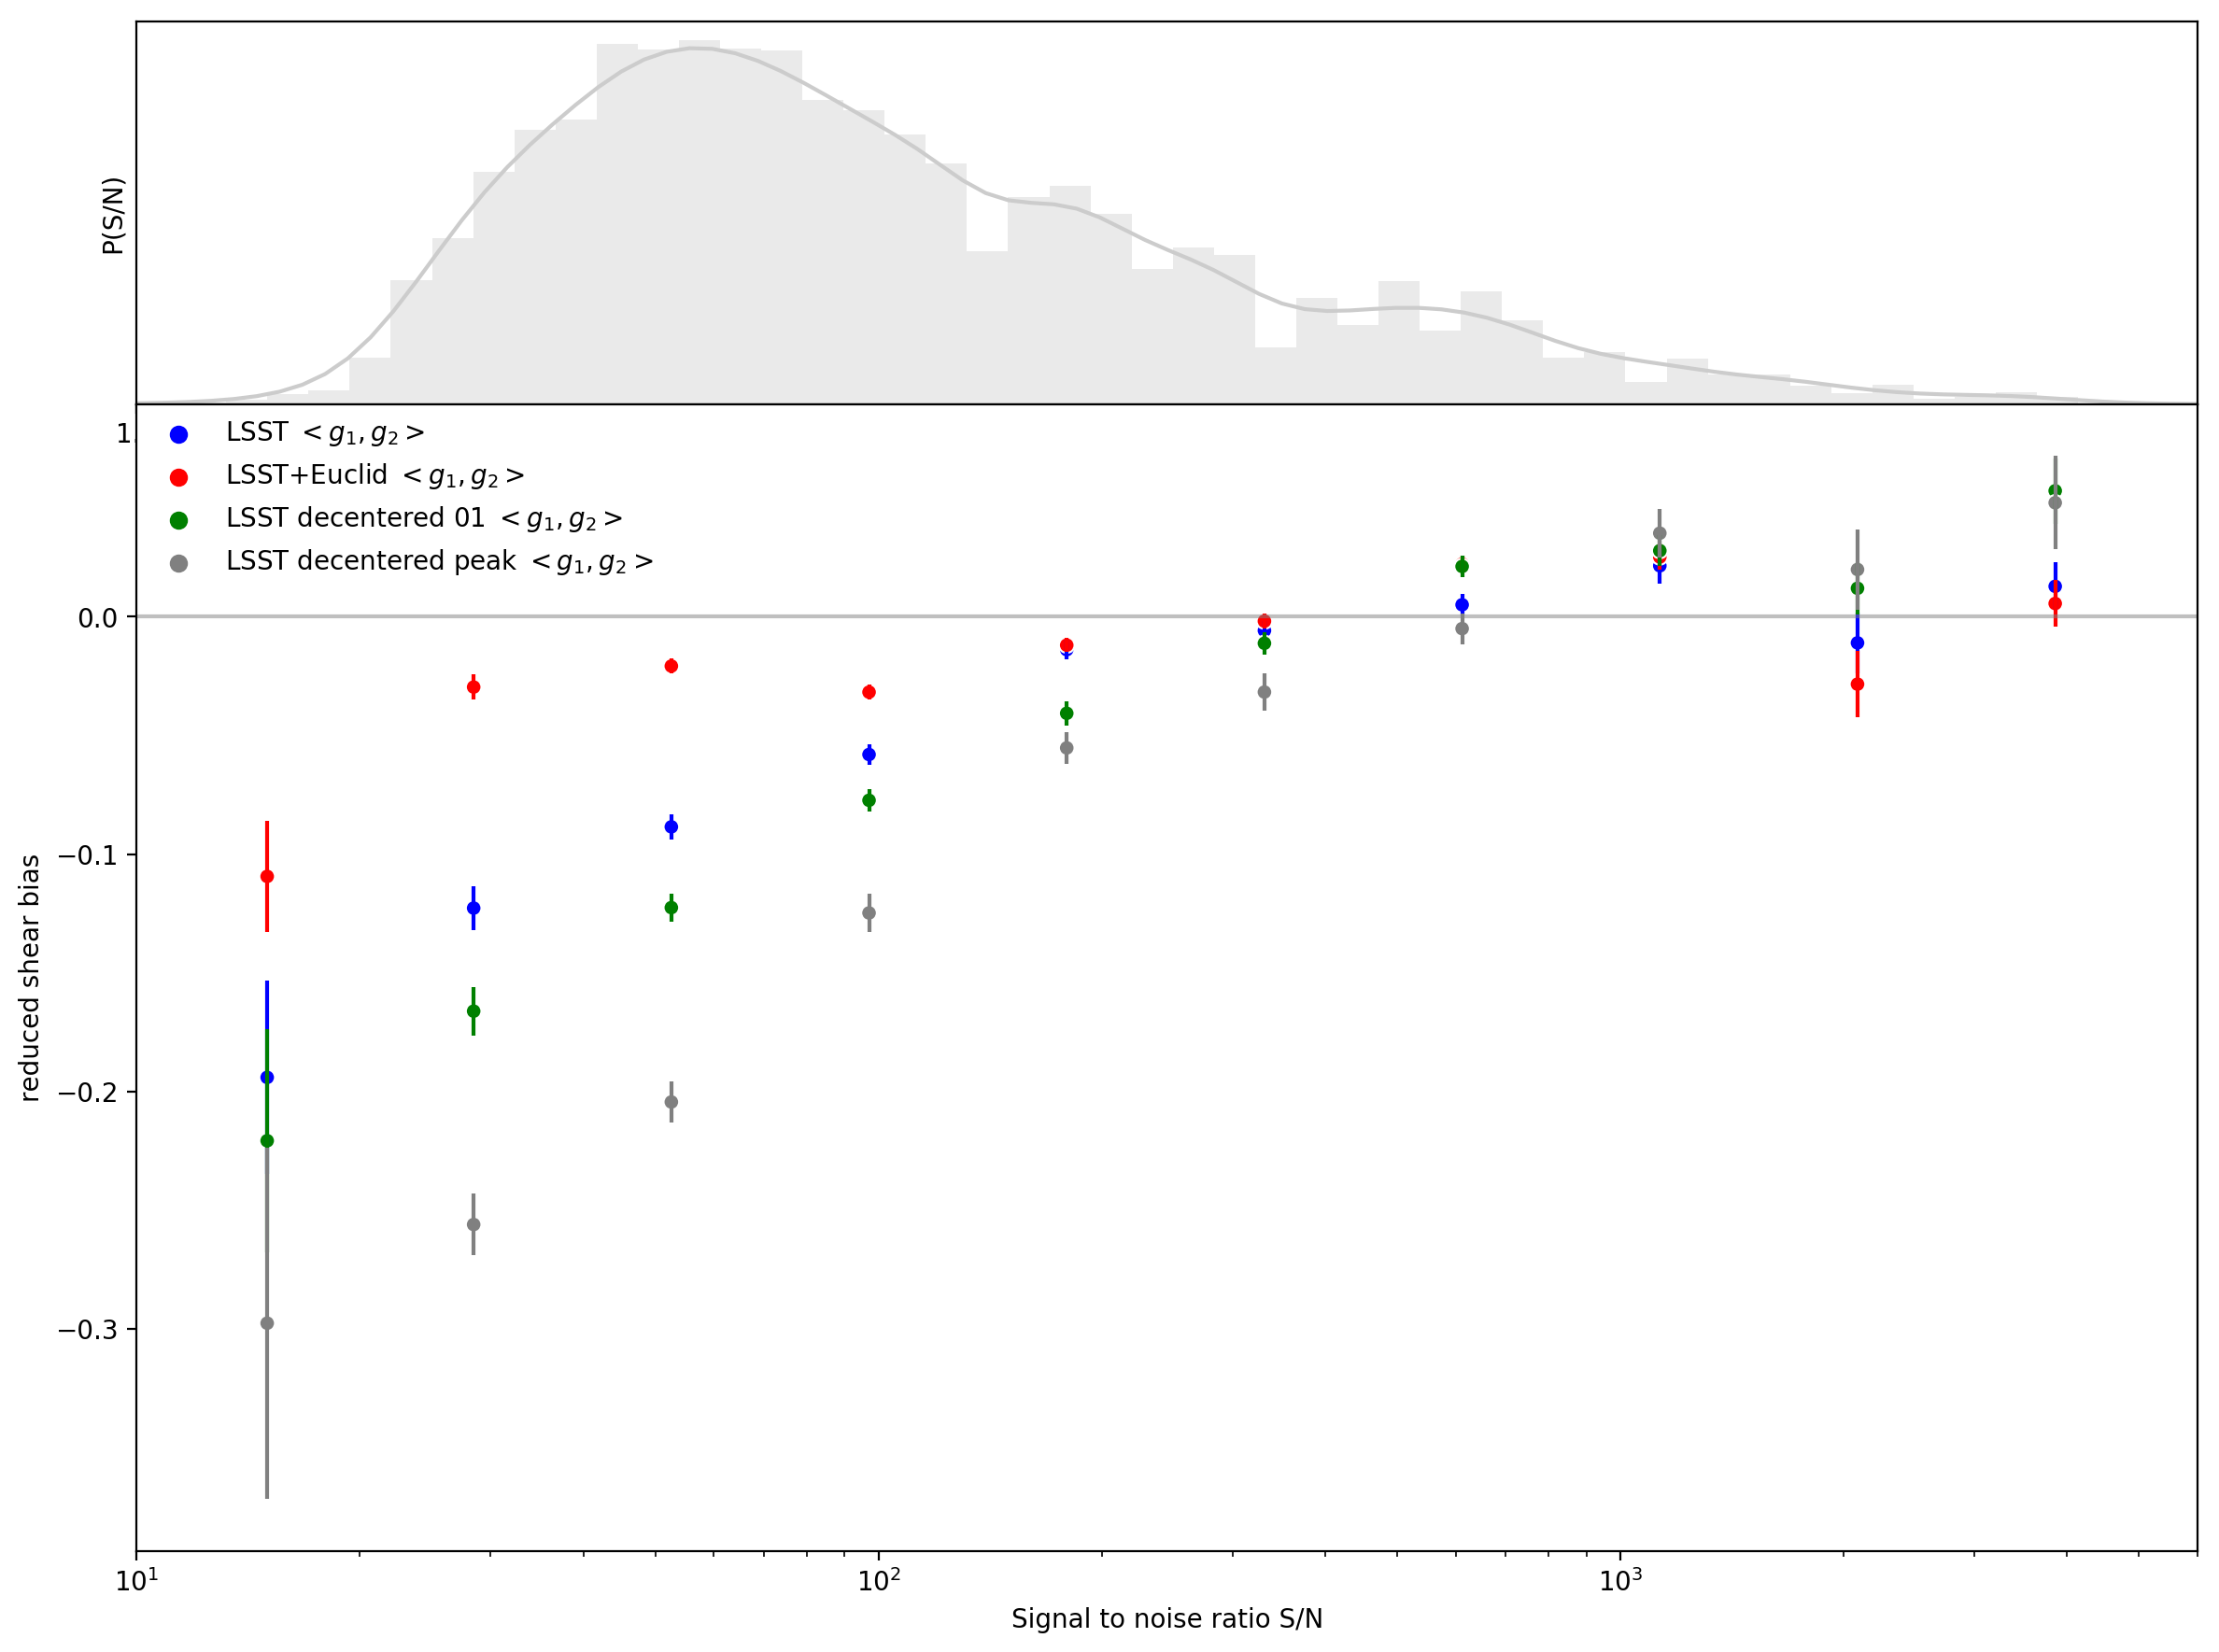

In [100]:
import matplotlib as mpl
mpl.rcdefaults()


fig, axes = plt.subplots(2, 1, figsize=(12,9),sharey='row', gridspec_kw={'height_ratios': [1, 3]})

palette_lsst = ['blue']
palette_lsst_euclid = ['red']
palette_lsst_01 = ['green']
palette_lsst_peak = ['grey']

xlim = (10,6000)
xscale = 'log'


sns.distplot(np.log10(df_lsst_centered[param]), ax=axes[0], color='0.8')
axes[0].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
axes[0].set_ylabel('P(S/N)')
axes[0].set_yticks([])

    
### For <g1, g2>

xlim = (10,6000)
handles = []
legend = []

axis = axes[1]
ax = sns.scatterplot(x="bins_list",
              y="mean_g", 
              hue="Experience",
              data=df_bias, 
              markers = '.',
              palette = [palette_lsst[0], palette_lsst_euclid[0], palette_lsst_01[0], palette_lsst_peak[0]],
              #label = ['LSST $|g_'+str(k+1)+'|$','LSST+Euclid $|g_'+str(k+1)+'|$'],
              ax = axis)
print(ax.get_legend_handles_labels()[1])

handles.append(ax.get_legend_handles_labels()[0][1])
handles.append(ax.get_legend_handles_labels()[0][2])
handles.append(ax.get_legend_handles_labels()[0][3])
handles.append(ax.get_legend_handles_labels()[0][4])
legend.append('LSST $<g_1, g_2>$')
legend.append('LSST+Euclid $<g_1, g_2>$')
legend.append('LSST decentered 01 $<g_1, g_2>$')
legend.append('LSST decentered peak $<g_1, g_2>$')
# Find the x,y coordinates for each point
x_coords = []
y_coords = []

for i, idx in enumerate (df_bias['bins_list']):
    x_coords.append(idx)
    y_coords.append(df_bias["mean_g"][i])

colors = [palette_lsst[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_euclid[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_01[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_peak[0]]*int(len(df_bias['bins_list'])/4)

axis.errorbar(x_coords, 
             y_coords, 
             yerr=df_bias['mean_stderr'],
             ecolor=colors,
             fmt=' ')


axis.legend(handles, legend, frameon=False, loc ='upper left', borderpad = 0.1, fontsize = 10)#, colors = ['steelblue','coral','blue','red'])
axis.set_xlabel('Signal to noise ratio S/N')
axis.axhline(0, color = 'grey', alpha = 0.5)
axis.set_xscale(xscale)
axis.set_xlim(xlim)
axis.set_ylabel('reduced shear bias')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [101]:
df_bias_all_sample = pd.DataFrame()
param = 'SNR'
#df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & (df_lsst_euclid['e2_out']<=1.)]

bins = np.geomspace(20, 5000, 1)
#bins = np.linspace(0.1, 1, 10)

for k in range (2):
    slope = []
    intercept = []
    std_err = []
    mean_e=[]

    mask = ~np.isnan(df_lsst_centered['e_in']) & ~np.isnan(df_lsst_centered['e_out'])

    df_test = df_lsst_centered[(np.abs(df_lsst_centered['e1_out'])<=1.) & 
                               (np.abs(df_lsst_centered['e2_out'])<=1.) &
                               (np.abs(df_lsst_centered['e1_in'])<=1.) & 
                               (np.abs(df_lsst_centered['e2_in'])<=1.) &
                               (df_lsst_centered['e_out']>=0.) & 
                               (df_lsst_centered['e_out']<=1.) &
                               (df_lsst_centered['e_in']>=0.) & 
                               (df_lsst_centered['e_in']<=1.)]
    slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
    intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
    std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])


    mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
    df_test = df_lsst_euclid[(np.abs(df_lsst_euclid['e1_out'])<=1.) & 
                             (np.abs(df_lsst_euclid['e2_out'])<=1.) &
                             (np.abs(df_lsst_euclid['e1_in'])<=1.) & 
                             (np.abs(df_lsst_euclid['e2_in'])<=1.) &
                             (df_lsst_euclid['e_out']>=0.) & 
                             (df_lsst_euclid['e_out']<=1.) &
                             (df_lsst_euclid['e_in']>=0.) & 
                             (df_lsst_euclid['e_in']<=1.)]
    slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
    intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
    std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])


    mask = ~np.isnan(df_lsst_01['e_in']) & ~np.isnan(df_lsst_01['e_out'])
    df_test = df_lsst_01[(np.abs(df_lsst_01['e1_out'])<=1.) & 
                         (np.abs(df_lsst_01['e2_out'])<=1.) &
                         (np.abs(df_lsst_01['e1_in'])<=1.) & 
                         (np.abs(df_lsst_01['e2_in'])<=1.) &
                         (df_lsst_01['e_out']>=0.) & 
                         (df_lsst_01['e_out']<=1.) &
                         (df_lsst_01['e_in']>=0.) & 
                         (df_lsst_01['e_in']<=1.)]
    slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
    intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
    std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])


    mask = ~np.isnan(df_lsst_peak['e_in']) & ~np.isnan(df_lsst_peak['e_out'])
    df_test = df_lsst_peak[(np.abs(df_lsst_peak['e1_out'])<=1.) & 
                           (np.abs(df_lsst_peak['e2_out'])<=1.) &
                           (np.abs(df_lsst_peak['e1_in'])<=1.) & 
                           (np.abs(df_lsst_peak['e2_in'])<=1.) &
                           (df_lsst_peak['e_out']>=0.) & 
                           (df_lsst_peak['e_out']<=1.) &
                           (df_lsst_peak['e_in']>=0.) & 
                           (df_lsst_peak['e_in']<=1.) &
                           (df_lsst_peak['idx_closest_to_peak']== 0)]
    slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
    intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
    std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])

              
    df_bias_all_sample['slope_e'+str(k+1)] = np.array(slope)
    df_bias_all_sample['intercept_e'+str(k+1)] = np.array(intercept)
    df_bias_all_sample['std_err_e'+str(k+1)] = np.array(std_err)


In [102]:
len(df_lsst_peak[(np.abs(df_lsst_peak['e1_out'])<=1.) & 
               (np.abs(df_lsst_peak['e2_out'])<=1.) &
               (np.abs(df_lsst_peak['e1_in'])<=1.) & 
               (np.abs(df_lsst_peak['e2_in'])<=1.) &
               (df_lsst_peak['e_out']>=0.) & 
               (df_lsst_peak['e_out']<=1.) &
               (df_lsst_peak['e_in']>=0.) & 
               (df_lsst_peak['e_in']<=1.) &
               (df_lsst_peak['idx_closest_to_peak']== 0)])

8242

In [55]:
df_bias_all_sample

,slope_e1,intercept_e1,std_err_e1,slope_e2,intercept_e2,std_err_e2
0,-0.058464,0.000905,0.002489,-0.053849,-0.001813,0.002434
1,-0.013661,0.000510,0.001523,-0.018956,0.000976,0.001483
2,-0.082752,0.002292,0.002732,-0.080153,-0.000153,0.002699
3,-0.083313,-0.000088,0.003442,-0.084072,0.000496,0.003331


In [56]:
df_bias_all_sample['mean_e'] = np.mean([df_bias_all_sample['slope_e1'],df_bias_all_sample['slope_e2']], axis = 0)

In [57]:
df_bias_all_sample

,slope_e1,intercept_e1,std_err_e1,slope_e2,intercept_e2,std_err_e2,mean_e
0,-0.058464,0.000905,0.002489,-0.053849,-0.001813,0.002434,-0.056157
1,-0.013661,0.000510,0.001523,-0.018956,0.000976,0.001483,-0.016308
2,-0.082752,0.002292,0.002732,-0.080153,-0.000153,0.002699,-0.081453
3,-0.083313,-0.000088,0.003442,-0.084072,0.000496,0.003331,-0.083692


In [103]:
df_bias = pd.DataFrame()
param = 'SNR'
#df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & (df_lsst_euclid['e2_out']<=1.)]

bins = np.geomspace(30, 4000, 10)
#bins = np.linspace(0.1, 1, 10)

for k in range (2):
    slope = []
    intercept = []
    std_err = []
    bins_list = []

    bining_temp = 10
    mask = ~np.isnan(df_lsst_centered['e_in']) & ~np.isnan(df_lsst_centered['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_centered[(np.abs(df_lsst_centered['e1_out'])<=1.) & 
                                   (np.abs(df_lsst_centered['e2_out'])<=1.) &
                                   (np.abs(df_lsst_centered['e1_in'])<=1.) & 
                                   (np.abs(df_lsst_centered['e2_in'])<=1.) &
                                   (df_lsst_centered['e_out']>=0.) & 
                                   (df_lsst_centered['e_out']<=1.) &
                                   (df_lsst_centered['e_in']>=0.) & 
                                   (df_lsst_centered['e_in']<=1.) &
                                   (bining_temp <= df_lsst_centered[param]) &
                                   (df_lsst_centered[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_euclid[(np.abs(df_lsst_euclid['e1_out'])<=1.) & 
                                 (np.abs(df_lsst_euclid['e2_out'])<=1.) &
                                 (np.abs(df_lsst_euclid['e1_in'])<=1.) & 
                                 (np.abs(df_lsst_euclid['e2_in'])<=1.) &
                                 (df_lsst_euclid['e_out']>=0.) & 
                                 (df_lsst_euclid['e_out']<=1.) &
                                 (df_lsst_euclid['e_in']>=0.) & 
                                 (df_lsst_euclid['e_in']<=1.) &
                                 (bining_temp <= df_lsst_euclid[param]) &
                                 (df_lsst_euclid[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_01['e_in']) & ~np.isnan(df_lsst_01['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_01[(np.abs(df_lsst_01['e1_out'])<=1.) & 
                             (np.abs(df_lsst_01['e2_out'])<=1.) &
                             (np.abs(df_lsst_01['e1_in'])<=1.) & 
                             (np.abs(df_lsst_01['e2_in'])<=1.) &
                             (df_lsst_01['e_out']>=0.) & 
                             (df_lsst_01['e_out']<=1.) &
                             (df_lsst_01['e_in']>=0.) & 
                             (df_lsst_01['e_in']<=1.) &
                             (bining_temp <= df_lsst_01[param]) &
                             (df_lsst_01[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_peak['e_in']) & ~np.isnan(df_lsst_peak['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_peak[(np.abs(df_lsst_peak['e1_out'])<=1.) & 
                           (np.abs(df_lsst_peak['e2_out'])<=1.) &
                           (np.abs(df_lsst_peak['e1_in'])<=1.) & 
                           (np.abs(df_lsst_peak['e2_in'])<=1.) &
                           (df_lsst_peak['e_out']>=0.) & 
                           (df_lsst_peak['e_out']<=1.) &
                           (df_lsst_peak['e_in']>=0.) & 
                           (df_lsst_peak['e_in']<=1.) &
                           (bining_temp <= df_lsst_peak[param]) &
                           (df_lsst_peak[param]<= bining) &
                           (df_lsst_peak['idx_closest_to_peak']== 0)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining
              
    df_bias['slope_e'+str(k+1)] = np.array(slope)
    df_bias['intercept_e'+str(k+1)] = np.array(intercept)
    df_bias['std_err_e'+str(k+1)] = np.array(std_err)

In [104]:
list_mid_bins = []
idx_temp = 10
for i, idx in enumerate (bins_list):
    if i == 10:
        idx_temp = 10
    if i == 20:
        idx_temp = 10
    if i == 30:
        idx_temp = 10

    list_mid_bins.append(idx - (idx - idx_temp)/2)
    idx_temp = idx

In [105]:
df_bias['Experience'] = len(bins)*['LSST'] + len(bins)*['LSST+Euclid']+ len(bins)*['LSST 01'] + len(bins)*['LSST peak']
df_bias['bins_list'] = np.array(list_mid_bins)
df_bias['mean_g'] = np.mean([df_bias['slope_e1'],df_bias['slope_e2']], axis = 0)
df_bias['mean_stderr'] = np.mean([df_bias['std_err_e1'],df_bias['std_err_e2']], axis = 0)

['Experience', 'LSST', 'LSST+Euclid', 'LSST 01', 'LSST peak']


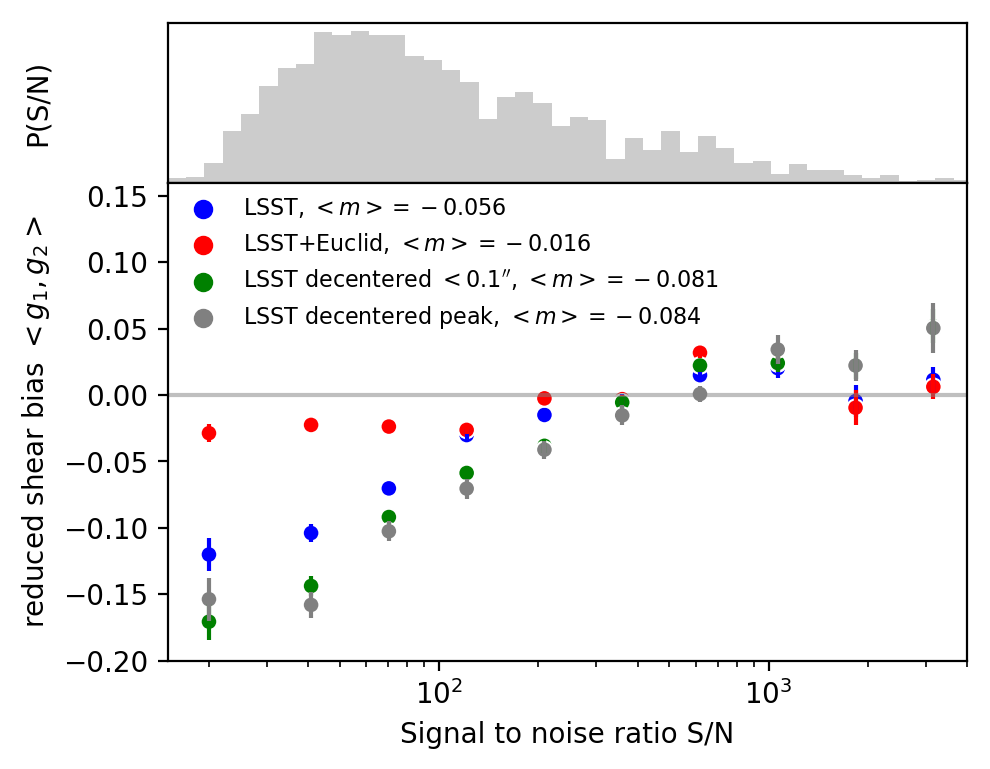

In [107]:
import matplotlib as mpl
mpl.rcdefaults()


fig, axes = plt.subplots(2, 1, figsize=(5,4),sharey='row', gridspec_kw={'height_ratios': [1, 3]})

palette_lsst = ['blue']
palette_lsst_euclid = ['red']
palette_lsst_01 = ['green']
palette_lsst_peak = ['grey']

xlim = (15,4000)
xscale = 'log'


sns.distplot(np.log10(df_lsst_centered[param]), ax=axes[0], color='0.5', kde = False)
axes[0].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
axes[0].set_ylabel('P(S/N)', fontsize = 10)
axes[0].set_yticks([])

    
### For <g1, g2>

xlim = (15,4000)
handles = []
legend = []

axis = axes[1]
ax = sns.scatterplot(x="bins_list",
              y="mean_g", 
              hue="Experience",
              data=df_bias, 
              markers = '.',
              palette = [palette_lsst[0], palette_lsst_euclid[0], palette_lsst_01[0], palette_lsst_peak[0]],
              #label = ['LSST $|g_'+str(k+1)+'|$','LSST+Euclid $|g_'+str(k+1)+'|$'],
              ax = axis)
print(ax.get_legend_handles_labels()[1])

handles.append(ax.get_legend_handles_labels()[0][1])
handles.append(ax.get_legend_handles_labels()[0][2])
handles.append(ax.get_legend_handles_labels()[0][3])
handles.append(ax.get_legend_handles_labels()[0][4])
legend.append('LSST, $<m> = -0.056$')
legend.append('LSST+Euclid, $<m> = -0.016$')
legend.append('LSST decentered $< 0.1^{\prime\prime}$, $<m> = -0.081$')
legend.append('LSST decentered peak, $<m> = -0.084$')
# Find the x,y coordinates for each point
x_coords = []
y_coords = []

for i, idx in enumerate (df_bias['bins_list']):
    x_coords.append(idx)
    y_coords.append(df_bias["mean_g"][i])

colors = [palette_lsst[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_euclid[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_01[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_peak[0]]*int(len(df_bias['bins_list'])/4)

axis.errorbar(x_coords, 
             y_coords, 
             yerr=df_bias['mean_stderr'],
             ecolor=colors,
             fmt=' ')


axis.legend(handles, legend, frameon=False, loc ='upper left', borderpad = 0.1, fontsize = 8)#, ncol=2)#, colors = ['steelblue','coral','blue','red'])
axis.set_xlabel('Signal to noise ratio S/N', fontsize = 10)
axis.axhline(0, color = 'grey', alpha = 0.5)
axis.set_xscale(xscale)
axis.set_xlim(xlim)
axis.set_ylim(-0.2,0.16)
axis.set_ylabel('reduced shear bias $<g_1, g_2>$', fontsize = 10)

fig.align_ylabels(axes)  
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig('figures_v2/bias_v4.pdf', dpi = 300)

In [247]:
df_lsst_centered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
Unnamed: 0                   10000 non-null int64
nb_blended_gal               10000 non-null int64
SNR                          10000 non-null float64
SNR_peak                     10000 non-null float64
redshift                     10000 non-null float64
moment_sigma                 10000 non-null float64
e1                           10000 non-null float64
e2                           10000 non-null float64
mag                          10000 non-null float64
mag_ir                       10000 non-null float64
closest_x                    7471 non-null float64
closest_y                    7471 non-null float64
closest_redshift             7471 non-null float64
closest_moment_sigma         7471 non-null float64
closest_e1                   7471 non-null float64
closest_e2                   7471 non-null float64
closest_mag                  7471 non-null float64
closest_mag_ir     

In [248]:
df_bias = pd.DataFrame()
param = 'blendedness_total_lsst'
#df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & (df_lsst_euclid['e2_out']<=1.)]

#bins = np.geomspace(30, 5000, 10)
bins = np.linspace(0.05, 0.55, 10)

for k in range (2):
    slope = []
    intercept = []
    std_err = []
    bins_list = []

    bining_temp = 0.
    mask = ~np.isnan(df_lsst_centered['e_in']) & ~np.isnan(df_lsst_centered['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_centered[(np.abs(df_lsst_centered['e1_out'])<=1.) & 
                          (np.abs(df_lsst_centered['e2_out'])<=1.) &
                          (df_lsst_centered['e_out']>=0.) & 
                          (np.abs(df_lsst_centered['e_out'])<=1.) &
                          (df_lsst_centered['nb_blended_gal']>1) &
                          (bining_temp <= df_lsst_centered[param]) &
                          (df_lsst_centered[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 0.
    mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_euclid[(np.abs(df_lsst_euclid['e1_out'])<=1.) & 
                                 (np.abs(df_lsst_euclid['e2_out'])<=1.) &
                                 (df_lsst_euclid['e_out']>=0.) & 
                                 (np.abs(df_lsst_euclid['e_out'])<=1.) &
                                 (df_lsst_euclid['nb_blended_gal']>1) &
                                 (bining_temp <= df_lsst_euclid[param]) &
                                 (df_lsst_euclid[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 0.
    mask = ~np.isnan(df_lsst_01['e_in']) & ~np.isnan(df_lsst_01['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_01[(np.abs(df_lsst_01['e1_out'])<=1.) & 
                                 (np.abs(df_lsst_01['e2_out'])<=1.) &
                                 (df_lsst_01['e_out']>=0.) & 
                                 (np.abs(df_lsst_01['e_out'])<=1.) &
                                 (df_lsst_01['nb_blended_gal']>1) &
                                 (bining_temp <= df_lsst_01[param]) &
                                 (df_lsst_01[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining

    bining_temp = 0.
    mask = ~np.isnan(df_lsst_peak['e_in']) & ~np.isnan(df_lsst_peak['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_peak[(np.abs(df_lsst_peak['e1_out'])<=1.) & 
                                 (np.abs(df_lsst_peak['e2_out'])<=1.) &
                                 (df_lsst_peak['e_out']>=0.) & 
                                 (np.abs(df_lsst_peak['e_out'])<=1.) &
                                   (df_lsst_peak['nb_blended_gal']>1) &
                                 (bining_temp <= df_lsst_peak[param]) &
                                 (df_lsst_peak[param]<= bining) &
                                 (df_lsst_peak['idx_closest_to_peak']== 0)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)
        bining_temp = bining
              
    df_bias['slope_e'+str(k+1)] = np.array(slope)
    df_bias['intercept_e'+str(k+1)] = np.array(intercept)
    df_bias['std_err_e'+str(k+1)] = np.array(std_err)

In [249]:
list_mid_bins = []
idx_temp = 10
for i, idx in enumerate (bins_list):
    if i == 10:
        idx_temp = 10
    if i == 20:
        idx_temp = 10
    if i == 30:
        idx_temp = 10

    list_mid_bins.append(idx - (idx - idx_temp)/2)
    idx_temp = idx

In [250]:
df_bias['Experience'] = len(bins)*['LSST'] + len(bins)*['LSST+Euclid']+ len(bins)*['LSST 01'] + len(bins)*['LSST peak']
df_bias['bins_list'] = np.array(list_mid_bins)
df_bias['mean_g'] = np.mean([df_bias['slope_e1'],df_bias['slope_e2']], axis = 0)
df_bias['mean_stderr'] = np.mean([df_bias['std_err_e1'],df_bias['std_err_e2']], axis = 0)

['Experience', 'LSST', 'LSST+Euclid', 'LSST 01', 'LSST peak']


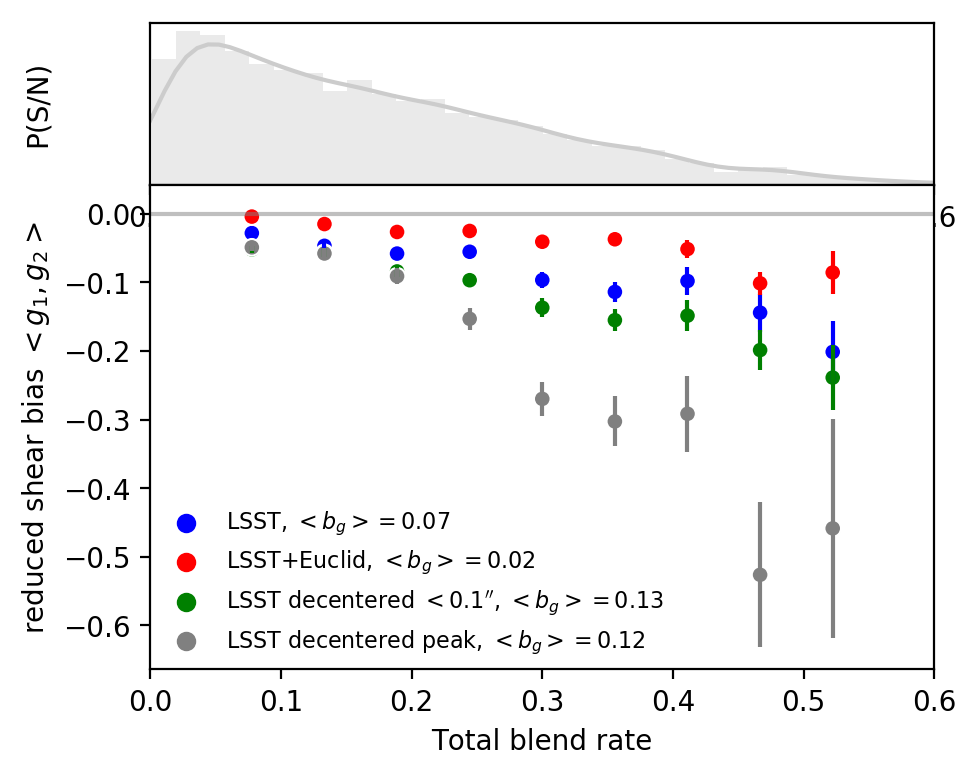

In [251]:
import matplotlib as mpl
mpl.rcdefaults()


fig, axes = plt.subplots(2, 1, figsize=(5,4),sharey='row', gridspec_kw={'height_ratios': [1, 3]})

palette_lsst = ['blue']
palette_lsst_euclid = ['red']
palette_lsst_01 = ['green']
palette_lsst_peak = ['grey']

xlim = (0,0.6)
xscale = 'linear'


sns.distplot(df_lsst_centered[df_lsst_centered['nb_blended_gal']>1][param], ax=axes[0], color='0.8')
axes[0].set_xlim(xlim[0], xlim[1])
axes[0].set_ylabel('P(S/N)', fontsize = 10)
axes[0].set_yticks([])

    
### For <g1, g2>

xlim = (0,0.6)
handles = []
legend = []

axis = axes[1]
ax = sns.scatterplot(x="bins_list",
              y="mean_g", 
              hue="Experience",
              data=df_bias, 
              markers = '.',
              palette = [palette_lsst[0], palette_lsst_euclid[0], palette_lsst_01[0], palette_lsst_peak[0]],
              #label = ['LSST $|g_'+str(k+1)+'|$','LSST+Euclid $|g_'+str(k+1)+'|$'],
              ax = axis)
print(ax.get_legend_handles_labels()[1])

handles.append(ax.get_legend_handles_labels()[0][1])
handles.append(ax.get_legend_handles_labels()[0][2])
handles.append(ax.get_legend_handles_labels()[0][3])
handles.append(ax.get_legend_handles_labels()[0][4])
legend.append('LSST, $< b_g> = 0.07$')
legend.append('LSST+Euclid, $< b_g> = 0.02$')
legend.append('LSST decentered $< 0.1^{\prime\prime}$, $< b_g> = 0.13$')
legend.append('LSST decentered peak, $< b_g> = 0.12$')
# Find the x,y coordinates for each point
x_coords = []
y_coords = []

for i, idx in enumerate (df_bias['bins_list']):
    x_coords.append(idx)
    y_coords.append(df_bias["mean_g"][i])

colors = [palette_lsst[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_euclid[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_01[0]]*int(len(df_bias['bins_list'])/4) + [palette_lsst_peak[0]]*int(len(df_bias['bins_list'])/4)

axis.errorbar(x_coords, 
             y_coords, 
             yerr=df_bias['mean_stderr'],
             ecolor=colors,
             fmt=' ')


axis.legend(handles, legend, frameon=False, loc ='lower left', borderpad = 0.1, fontsize = 8)#, ncol=2)#, colors = ['steelblue','coral','blue','red'])
axis.set_xlabel('Total blend rate', fontsize = 10)
axis.axhline(0, color = 'grey', alpha = 0.5)
axis.set_xscale(xscale)
axis.set_xlim(xlim)
#axis.set_ylim(-0.18,0.16)
axis.set_ylabel('reduced shear bias $<g_1, g_2>$', fontsize = 10)

fig.align_ylabels(axes)  
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

#fig.savefig('figures/bias_blendedness_total_v1.pdf', dpi = 300)